In [229]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [230]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
!pip install overrides

  Created wheel for overrides: filename=overrides-2.8.0-cp36-none-any.whl size=5609 sha256=703eb6f1435aabbc87d37b54915fa797353fd057d0ffccb39c03bfd4be233468
  Stored in directory: /root/.cache/pip/wheels/df/f1/ba/eaf6cd7d284d2f257dc71436ce72d25fd3be5a5813a37794ab
Successfully built overrides


In [4]:
!pip install allennlp

     |████████████████████████████████| 7.6MB 7.6MB/s 
     |████████████████████████████████| 245kB 61.1MB/s 
     |████████████████████████████████| 61kB 11.2MB/s 
     |████████████████████████████████| 133kB 65.4MB/s 
     |████████████████████████████████| 51kB 9.4MB/s 
     |████████████████████████████████| 204kB 66.3MB/s 
     |████████████████████████████████| 256kB 66.0MB/s 
     |████████████████████████████████| 163kB 62.1MB/s 
     |████████████████████████████████| 1.0MB 65.7MB/s 
  Created wheel for numpydoc: filename=numpydoc-0.9.2-cp36-none-any.whl size=31893 sha256=7d67c4ec274461f765d83ad488cc32bb2e2fb36787aa7777637b845ce51160f6
  Stored in directory: /root/.cache/pip/wheels/96/f3/52/25c8e1f40637661d27feebc61dae16b84c7cdd93b8bc3d7486
  Created wheel for ftfy: filename=ftfy-5.7-cp36-none-any.whl size=44593 sha256=2d33e400a29a166e285d1f2832d2329c6b691104f73a9e955afdabe2924c88b0
  Stored in directory: /root/.cache/pip/wheels/8e/da/59/6c8925d571aacade638a0f515960c21c0887a

In [0]:
from pathlib import Path
from typing import *
import torch
import torch.optim as optim
import numpy as np
import pandas as pd
from functools import partial
from overrides import overrides

from allennlp.data import Instance
from allennlp.data.token_indexers import TokenIndexer
from allennlp.data.tokenizers import Token
from allennlp.nn import util as nn_util

In [0]:
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)
        
config = Config(
    testing=True,
    seed=1,
    batch_size=32,
    lr=3e-4,
    epochs=5,
    hidden_sz=64,
    max_seq_len=360, # necessary to limit memory usage
    max_vocab_size=100000,
)

In [0]:
from allennlp.common.checks import ConfigurationError
USE_GPU = torch.cuda.is_available()
DATA_ROOT = Path("src") / ""
USE_GPU

Set random seed manually to replicate results

In [11]:
torch.manual_seed(config.seed)

In [13]:
cd 'drive/My Drive/Brown Datathon/'

/content/drive/My Drive/Brown Datathon


In [14]:
cd 'Wiki_Semantic_Intention'

/content/drive/My Drive/Brown Datathon/Wiki_Semantic_Intention


# Load Data

In [0]:
from allennlp.data.vocabulary import Vocabulary
from allennlp.data.dataset_readers import DatasetReader

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

#Splitting to train on Amazon MTurk & 3rd party Edit Intent Dataset and validate on MTurn dataset

df1 = pd.read_csv('ps_pe_data2.csv')
trdata1, tedata1 = train_test_split(df1, train_size=0.8)
df2 = pd.read_csv('ps_pe_4.csv')
df = df2.append(trdata1)
trdata, tedata = df, tedata1

### Prepare dataset

In [378]:
label_cols = df['label'].unique().tolist()
print(label_cols)

id2labels = {}
for idx,i in enumerate(label_cols):
    id2labels[i] = idx 

['Elaboration(insert a fact or new meaningful assertion, update numbers, dates, scores etc)', 'Copy Editing(Rephrase without changing meaning,  improve grammar etc)', 'Wikification ( formating style, adding or removing links etc)', 'Adding spammy, useless or derogatory content', 'Other']


In [0]:
from allennlp.data.fields import TextField, MetadataField, ArrayField

class IntentClsDatasetReader(DatasetReader):
    def __init__(self, tokenizer: Callable[[str], List[str]]=lambda x: x.split(),
                 token_indexers: Dict[str, TokenIndexer] = None,
                 max_seq_len: Optional[int]=config.max_seq_len) -> None:
        super().__init__(lazy=False)
        self.tokenizer = tokenizer
        self.token_indexers = token_indexers or {"tokens": SingleIdTokenIndexer()}
        self.max_seq_len = max_seq_len

    @overrides
    def text_to_instance(self, tokens: List[Token], id: str=None,
                         labels: np.ndarray=None) -> Instance:
        sentence_field = TextField(tokens, self.token_indexers)
        fields = {"sentence_tokens": sentence_field}
        
        id_field = MetadataField(id)
        fields["id"] = id_field
        
        labels = np.asarray([labels])
        label_field = ArrayField(array=labels)
        fields["label"] = label_field

        return Instance(fields)
    
    @overrides
    def _read(self, df: str) -> Iterator[Instance]:
        #df = pd.read_csv(file_path)
        #if config.testing: df = df.head(1000)
        for i, row in df.iterrows():
            yield self.text_to_instance(
                [Token(x) for x in self.tokenizer("[CLS]"+row["edited_sentence"]+'[PSTR]'+row['phrase']+'[PEND]')],
                i, id2labels[row['label']],
            )

### Prepare token handlers

We will use the spacy tokenizer here

In [0]:
from allennlp.data.token_indexers import PretrainedBertIndexer

token_indexer = PretrainedBertIndexer(
    pretrained_model="bert-base-uncased",
    max_pieces=config.max_seq_len,
    do_lowercase=True,
 )

In [0]:
from pytorch_pretrained_bert.tokenization import BertTokenizer
bert_tokenizer_obj = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

def bert_tokenizer(s: str):
    if type(s) == str:
      tokens = bert_tokenizer_obj.basic_tokenizer.tokenize(s)[:360]
    else:
      tokens = ['[UNK]']
    return tokens

In [0]:
reader = IntentClsDatasetReader(
    tokenizer=bert_tokenizer,
    token_indexers={"tokens": token_indexer}
)

In [384]:
train_ds = [reader.read(trdata)][0]
val_ds = None

5237it [00:35, 147.56it/s]


### Prepare vocabulary

We don't need to build the vocab: all that is handled by the token indexer

In [0]:
vocab = Vocabulary()

### Prepare iterator

The iterator is responsible for batching the data and preparing it for input into the model. We'll use the BucketIterator that batches text sequences of smilar lengths together.

In [0]:
from allennlp.data.iterators import BasicIterator, BucketIterator

In [0]:
iterator = BasicIterator(batch_size=config.batch_size)

We need to tell the iterator how to numericalize the text data. We do this by passing the vocabulary to the iterator. This step is easy to forget so be careful! 

In [0]:
iterator.index_with(vocab)

# Prepare Model

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

In [0]:
from allennlp.modules.seq2vec_encoders import Seq2VecEncoder, PytorchSeq2VecWrapper
from allennlp.nn.util import get_text_field_mask
from allennlp.models import Model
from allennlp.modules.text_field_embedders import TextFieldEmbedder
import torch.nn

class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.other = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs, l1, l2):
        seq_len = len(encoder_outputs)

        attn_energies = self.score(hidden, encoder_outputs)
        s_mask = attn_energies.data.new(*attn_energies.size()).fill_(1).byte()  # [B, T1, T2]
        # Init similarity mask using lengths
        for i, (l_1, l_2) in enumerate(zip(l1, l2)):
            s_mask[i][:l_1, :l_2] = 0

        attn_energies.data.masked_fill_(s_mask.byte(), -math.inf)
        attn_energies = F.softmax(attn_energies)
        attn_energies.data.masked_fill_(attn_energies.data != attn_energies.data, 0)
        return attn_energies
    
    def score(self, hidden, encoder_output):
        
        if self.method == 'dot':
            energy = hidden.dot(encoder_output)
            return energy
        
        elif self.method == 'general':
            energy = self.attn(encoder_output)
            energy = torch.bmm(hidden,energy.transpose(1,2))
            return energy
        
        elif self.method == 'concat':
            energy = self.attn(torch.cat((hidden, encoder_output), 1))
            energy = self.other.dot(energy)
            return energy

class BaselineModel(nn.Module):
    def __init__(self,
                 rnn_size_in=(1024 + 300, 1024 + 300),
                 rnn_size_out=(300, 300), max_l=150,
                 mlp_d=300, num_of_class=3, drop_r=0.5, activation_type='relu'):
        super(BaselineModel, self).__init__()
        self.dropout_layer = nn.Dropout(drop_r)

        self.lstm_1 = nn.LSTM(input_size=rnn_size_in[0], hidden_size=rnn_size_out[0],
                              num_layers=1, bidirectional=True, batch_first=True)

        self.lstm_2 = nn.LSTM(input_size=rnn_size_in[1], hidden_size=rnn_size_out[1],
                              num_layers=1, bidirectional=True, batch_first=True)

        self.attn = Attn('general', rnn_size_out[0] * 2)
        self.projection = nn.Linear(rnn_size_out[0] * 2 * 2, rnn_size_out[0])
        
        self.max_l = max_l
        self.bidaf = biDafAttn(300)

        self.mlp_1 = nn.Linear(rnn_size_out[1] * 2, mlp_d)
        self.sm = nn.Linear(mlp_d, num_of_class)

        if activation_type == 'relu':
            activation = nn.ReLU()
        elif activation_type == 'tanh':
            activation = nn.Tanh()
        else:
            raise ValueError("Not a valid activation!")

        self.classifier = nn.Sequential(*[nn.Dropout(drop_r), self.mlp_1, activation, nn.Dropout(drop_r), self.sm])
    
    def forward(self, layer1_s1, layer2_s1, l1):
        p_s1 = self.dropout_layer(layer1_s1)
        
        tot_len1 = layer1_s1.size(1)
        s1_layer1_out = auto_rnn(self.lstm_1, p_s1, l1, tot_len=tot_len1)
        
        S = self.bidaf.similarity(s1_layer1_out, l1, s1_layer1_out, l1)
        
        a_weight = F.softmax(S, dim=2)  # [B, t1, t2]
        a_weight.data.masked_fill_(a_weight.data != a_weight.data, 0)  # remove nan from softmax on -inf

        s1_att, s2_att = self.bidaf.get_both_tile(S, s1_layer1_out, s1_layer1_out)

        s1_coattentioned = torch.cat([s1_layer1_out, s1_att], dim=2)

        #Luong Attention
        '''attn_weights = self.attn(s1_layer1_out, s1_layer1_out, l1, l1)
        s1_layer1_outcontext = attn_weights.bmm(s1_layer1_out)
        
        s1_coattentioned = torch.cat([s1_layer1_out, s1_layer1_outcontext], dim=2)'''
        
        p_s1_coattentioned = F.relu(self.projection(s1_coattentioned))
        
        s1_coatt_features = torch.cat([p_s1_coattentioned, layer2_s1], dim=2)
        
        s1_coatt_features = self.dropout_layer(s1_coatt_features)

        s1_layer2_out = auto_rnn(self.lstm_2, s1_coatt_features, l1, tot_len=s1_coatt_features.size(1))
        s1_lay2_maxout = max_along_time(s1_layer2_out, l1)
        
        return self.classifier(s1_lay2_maxout), a_weight

# Torch util

In [0]:
import torch
from torch import nn
import torch.nn.functional as F
import math


class biDafAttn(nn.Module):
    def __init__(self, channel_size):
        super(biDafAttn, self).__init__()
        """
        This method do biDaf from s2 to s1:
            The return value will have the same size as s1.
        :param channel_size: Hidden size of the input
        """

    def similarity(self, s1, l1, s2, l2, masked=True):
        """
        :param s1: [B, t1, D]
        :param l1: [B]
        :param s2: [B, t2, D]
        :param l2: [B]
        :return:
        """
        batch_size = s1.size(0)
        t1 = s1.size(1)
        t2 = s2.size(1)
        S = torch.bmm(s1, s2.transpose(1, 2))
        # [B, t1, D] * [B, D, t2] -> [B, t1, t2] S is the similarity matrix from biDAF paper. [B, T1, T2]

        if masked:
            s_mask = S.data.new(*S.size()).fill_(1).byte()  # [B, T1, T2]
            # Init similarity mask using lengths
            for i, (l_1, l_2) in enumerate(zip(l1, l2)):
                s_mask[i][:l_1, :l_2] = 0

            S.data.masked_fill_(s_mask.byte(), -math.inf)
        return S

    def get_U_tile(self, S, s2):
        a_weight = F.softmax(S, dim=2)  # [B, t1, t2]
        a_weight.data.masked_fill_(a_weight.data != a_weight.data, 0)  # remove nan from softmax on -inf
        U_tile = torch.bmm(a_weight, s2)  # [B, t1, t2] * [B, t2, D] -> [B, t1, D]
        return U_tile

    def get_V_tile(self, S, s1):
        a1_weight = F.softmax(S, dim=1)  # [B, t1, t2]
        a1_weight.data.masked_fill_(a1_weight.data != a1_weight.data, 0)  # remove nan from softmax on -inf
        U1_tile = torch.bmm(a1_weight.transpose(1, 2), s1)  # [B, t2, t1] * [B, t1, D] -> [B, t2, D]
        return U1_tile

    def get_both_tile(self, S, s1, s2, retweight=False):
        a_weight = F.softmax(S, dim=2)  # [B, t1, t2]
        a_weight.data.masked_fill_(a_weight.data != a_weight.data, 0)  # remove nan from softmax on -inf
        U_tile = torch.bmm(a_weight, s2)  # [B, t1, t2] * [B, t2, D] -> [B, t1, D]

        a1_weight = F.softmax(S, dim=1)  # [B, t1, t2]
        a1_weight.data.masked_fill_(a1_weight.data != a1_weight.data, 0)  # remove nan from softmax on -inf
        U1_tile = torch.bmm(a1_weight.transpose(1, 2), s1)  # [B, t2, t1] * [B, t1, D] -> [B, t2, D]
        if not retweight:
            return U_tile, U1_tile
        else:
            return U_tile, U1_tile, a1_weight

    def forward(self, s1, l1, s2, l2):
        S = self.similarity(s1, l1, s2, l2)
        U_tile = self.get_U_tile(S, s2)
        return U_tile

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import functools

from allennlp.nn.util import get_lengths_from_binary_sequence_mask


def get_length_and_mask(seq):
    len_mask = (seq != 0).long()
    len_t = get_lengths_from_binary_sequence_mask(len_mask)
    return len_mask, len_t


def length_truncate(seq, max_l, is_elmo=False):
    def _truncate(seq):
        if seq.size(1) > max_l:
            return seq[:, :max_l, ...]
        else:
            return seq

    if not is_elmo:
        return _truncate(seq)
    else:
        s1_elmo_embd = dict()
        s1_elmo_embd['mask'] = _truncate(seq['mask'])
        s1_elmo_embd['elmo_representations'] = []
        for e_rep in seq['elmo_representations']:
            s1_elmo_embd['elmo_representations'].append(_truncate(e_rep))
        return s1_elmo_embd


def pad_1d(seq, pad_l):
    """
    The seq is a sequence having shape [T, ..]. Note: The seq contains only one instance. This is not batched.
    
    :param seq:  Input sequence with shape [T, ...]
    :param pad_l: The required pad_length.
    :return:  Output sequence will have shape [Pad_L, ...]
    """
    l = seq.size(0)
    if l >= pad_l:
        return seq[:pad_l, ]  # Truncate the length if the length is bigger than required padded_length.
    else:
        pad_seq = Variable(seq.data.new(pad_l - l, *seq.size()[1:]).zero_())  # Requires_grad is False
        return torch.cat([seq, pad_seq], dim=0)


def get_state_shape(rnn: nn.RNN, batch_size, bidirectional=False):
    """
    Return the state shape of a given RNN. This is helpful when you want to create a init state for RNN.

    Example:
    c0 = h0 = Variable(src_seq_p.data.new(*get_state_shape([your rnn], 3, bidirectional)).zero_())
    
    :param rnn: nn.LSTM, nn.GRU or subclass of nn.RNN
    :param batch_size:  
    :param bidirectional:  
    :return: 
    """
    if bidirectional:
        return rnn.num_layers * 2, batch_size, rnn.hidden_size
    else:
        return rnn.num_layers, batch_size, rnn.hidden_size


def pack_list_sequence(inputs, l, max_l=None, batch_first=True):
    """
    Pack a batch of Tensor into one Tensor with max_length.
    :param inputs: 
    :param l: 
    :param max_l: The max_length of the packed sequence.
    :param batch_first: 
    :return: 
    """
    batch_list = []
    max_l = max(list(l)) if not max_l else max_l
    batch_size = len(inputs)

    for b_i in range(batch_size):
        batch_list.append(pad_1d(inputs[b_i], max_l))
    pack_batch_list = torch.stack(batch_list, dim=1) if not batch_first \
        else torch.stack(batch_list, dim=0)
    return pack_batch_list


def pack_for_rnn_seq(inputs, lengths, batch_first=True, states=None):
    """
    :param states: [rnn.num_layers, batch_size, rnn.hidden_size]
    :param inputs: Shape of the input should be [B, T, D] if batch_first else [T, B, D].
    :param lengths:  [B]
    :param batch_first: 
    :return: 
    """
    if not batch_first:
        _, sorted_indices = lengths.sort()
        '''
            Reverse to decreasing order
        '''
        r_index = reversed(list(sorted_indices))

        s_inputs_list = []
        lengths_list = []
        reverse_indices = np.zeros(lengths.size(0), dtype=np.int64)

        for j, i in enumerate(r_index):
            s_inputs_list.append(inputs[:, i, :].unsqueeze(1))
            lengths_list.append(lengths[i])
            reverse_indices[i] = j

        reverse_indices = list(reverse_indices)

        s_inputs = torch.cat(s_inputs_list, 1)
        packed_seq = nn.utils.rnn.pack_padded_sequence(s_inputs, lengths_list)

        return packed_seq, reverse_indices

    else:
        _, sorted_indices = lengths.sort()
        '''
            Reverse to decreasing order
        '''
        r_index = reversed(list(sorted_indices))

        s_inputs_list = []
        lengths_list = []
        reverse_indices = np.zeros(lengths.size(0), dtype=np.int64)

        if states is None:
            states = ()
        elif not isinstance(states, tuple):
            states = (states,)  # rnn.num_layers, batch_size, rnn.hidden_size

        states_lists = tuple([] for _ in states)

        for j, i in enumerate(r_index):
            s_inputs_list.append(inputs[i, :, :])
            lengths_list.append(lengths[i])
            reverse_indices[i] = j

            for state_list, state in zip(states_lists, states):
                state_list.append(state[:, i, :].unsqueeze(1))

        reverse_indices = list(reverse_indices)

        s_inputs = torch.stack(s_inputs_list, dim=0)
        packed_seq = nn.utils.rnn.pack_padded_sequence(s_inputs, lengths_list, batch_first=batch_first)

        r_states = tuple(torch.cat(state_list, dim=1) for state_list in states_lists)
        if len(r_states) == 1:
            r_states = r_states[0]

        return packed_seq, reverse_indices, r_states


def unpack_from_rnn_seq(packed_seq, reverse_indices, batch_first=True, tot_len=None):
    unpacked_seq, _ = nn.utils.rnn.pad_packed_sequence(packed_seq, batch_first=batch_first, total_length=tot_len)
    s_inputs_list = []

    if not batch_first:
        for i in reverse_indices:
            s_inputs_list.append(unpacked_seq[:, i, :].unsqueeze(1))
        return torch.cat(s_inputs_list, 1)
    else:
        for i in reverse_indices:
            s_inputs_list.append(unpacked_seq[i, :, :].unsqueeze(0))
        return torch.cat(s_inputs_list, 0)


def reverse_indice_for_state(states, reverse_indices):
    """
    :param states: [rnn.num_layers, batch_size, rnn.hidden_size]
    :param reverse_indices: [batch_size]
    :return:
    """
    if states is None:
        states = ()
    elif not isinstance(states, tuple):
        states = (states,)  # rnn.num_layers, batch_size, rnn.hidden_size

    states_lists = tuple([] for _ in states)
    for i in reverse_indices:
        for state_list, state in zip(states_lists, states):
            state_list.append(state[:, i, :].unsqueeze(1))

    r_states = tuple(torch.cat(state_list, dim=1) for state_list in states_lists)
    if len(r_states) == 1:
        r_states = r_states[0]
    return r_states


def auto_rnn(rnn: nn.RNN, seqs, lengths, batch_first=True, init_state=None, output_last_states=False, tot_len=None):
    batch_size = seqs.size(0) if batch_first else seqs.size(1)
    state_shape = get_state_shape(rnn, batch_size, rnn.bidirectional)

    # if init_state is None:
    #     h0 = c0 = Variable(seqs.data.new(*state_shape).zero_())
    # else:
    #     h0 = init_state[0] # rnn.num_layers, batch_size, rnn.hidden_size
    #     c0 = init_state[1]

    packed_pinputs, r_index, init_state = pack_for_rnn_seq(seqs, lengths, batch_first, init_state)

    if len(init_state) == 0:
        h0 = c0 = Variable(seqs.data.new(*state_shape).zero_())
        init_state = (h0, c0)

    #rnn.flatten_parameters()
    output, last_state = rnn(packed_pinputs, init_state)
    output = unpack_from_rnn_seq(output, r_index, batch_first, tot_len)

    if not output_last_states:
        return output
    else:
        last_state = reverse_indice_for_state(last_state, r_index)
        return output, last_state


def pack_sequence_for_linear(inputs, lengths, batch_first=True):
    """
    :param inputs: [B, T, D] if batch_first 
    :param lengths:  [B]
    :param batch_first:  
    :return: 
    """
    batch_list = []
    if batch_first:
        for i, l in enumerate(lengths):
            # print(inputs[i, :l].size())
            batch_list.append(inputs[i, :l])
        packed_sequence = torch.cat(batch_list, 0)
        # if chuck:
        #     return list(torch.chunk(packed_sequence, chuck, dim=0))
        # else:
        return packed_sequence
    else:
        raise NotImplemented()


def chucked_forward(inputs, net, chuck=None):
    if not chuck:
        return net(inputs)
    else:
        output_list = [net(chuck) for chuck in torch.chunk(inputs, chuck, dim=0)]
        return torch.cat(output_list, dim=0)


def unpack_sequence_for_linear(inputs, lengths, batch_first=True):
    batch_list = []
    max_l = max(lengths)

    if not isinstance(inputs, list):
        inputs = [inputs]
    inputs = torch.cat(inputs)

    if batch_first:
        start = 0
        for l in lengths:
            end = start + l
            batch_list.append(pad_1d(inputs[start:end], max_l))
            start = end
        return torch.stack(batch_list)
    else:
        raise NotImplemented()


def seq2seq_cross_entropy(logits, label, l, chuck=None, sos_truncate=True):
    """
    :param logits: [exB, V] : exB = sum(l)
    :param label: [B] : a batch of Label
    :param l: [B] : a batch of LongTensor indicating the lengths of each inputs
    :param chuck: Number of chuck to process
    :return: A loss value
    """
    packed_label = pack_sequence_for_linear(label, l)
    cross_entropy_loss = functools.partial(F.cross_entropy, size_average=False)
    total = sum(l)

    assert total == logits.size(0) or packed_label.size(0) == logits.size(0), \
        "logits length mismatch with label length."

    if chuck:
        logits_losses = 0
        for x, y in zip(torch.chunk(logits, chuck, dim=0), torch.chunk(packed_label, chuck, dim=0)):
            logits_losses += cross_entropy_loss(x, y)
        return logits_losses * (1 / total)
    else:
        return cross_entropy_loss(logits, packed_label) * (1 / total)


def cat_along_time(inputs1, inputs2, lengths1, lengths2):
    ls1 = list(lengths1)
    ls2 = list(lengths2)
    
    batchmax = max(ls1+ls2)

    b_seq_cat_list = []
    for i, (l1, l2) in enumerate(zip(ls1, ls2)):
        seq_i1 = inputs1[i, :l1, :]
        seq_i2 = inputs2[i, :l2, :]
        if inputs1.size(1) != l1:
            seq_i1_rest = torch.zeros(inputs1[i, l1:, :].shape).to(seq_i1.device)
        if inputs2.size(1) != l2:
            seq_i2_rest = torch.zeros(inputs2[i, l2:, :].shape).to(seq_i2.device)
        
        seq_i_cat = torch.cat([seq_i1, seq_i2], dim=0)
        if inputs1.size(1) != l1:
            seq_i_cat = torch.cat([seq_i_cat, seq_i1_rest], dim=0)
        if inputs2.size(1) != l2:
            seq_i_cat = torch.cat([seq_i_cat, seq_i2_rest], dim=0)
        b_seq_cat_list.append(seq_i_cat)

    return torch.stack(b_seq_cat_list)


def min_along_time(inputs, lengths, list_in=False):
    """
    :param inputs: [B, T, D] 
    :param lengths:  [B]
    :return: [B * D] max_along_time
    :param list_in: 
    """
    ls = list(lengths)

    if not list_in:
        b_seq_max_list = []
        for i, l in enumerate(ls):
            seq_i = inputs[i, :l, :]
            seq_i_max, _ = seq_i.min(dim=0)
            seq_i_max = seq_i_max.squeeze()
            b_seq_max_list.append(seq_i_max)

        return torch.stack(b_seq_max_list)
    else:
        b_seq_max_list = []
        for i, l in enumerate(ls):
            seq_i = inputs[i]
            seq_i_max, _ = seq_i.min(dim=0)
            seq_i_max = seq_i_max.squeeze()
            b_seq_max_list.append(seq_i_max)

        return torch.stack(b_seq_max_list)
        
def max_along_time(inputs, lengths, list_in=False):
    """
    :param inputs: [B, T, D] 
    :param lengths:  [B]
    :return: [B * D] max_along_time
    :param list_in: 
    """
    ls = list(lengths)

    if not list_in:
        b_seq_max_list = []
        for i, l in enumerate(ls):
            seq_i = inputs[i, :l, :]
            seq_i_max, _ = seq_i.max(dim=0)
            seq_i_max = seq_i_max.squeeze()
            b_seq_max_list.append(seq_i_max)

        return torch.stack(b_seq_max_list)
    else:
        b_seq_max_list = []
        for i, l in enumerate(ls):
            seq_i = inputs[i]
            seq_i_max, _ = seq_i.max(dim=0)
            seq_i_max = seq_i_max.squeeze()
            b_seq_max_list.append(seq_i_max)

        return torch.stack(b_seq_max_list)


def avg_along_time(inputs, lengths, list_in=False):
    """
    :param inputs: [B, T, D]
    :param lengths:  [B]
    :return: [B * D] max_along_time
    :param list_in:
    """
    ls = list(lengths)

    if not list_in:
        b_seq_avg_list = []
        for i, l in enumerate(ls):
            seq_i = inputs[i, :l, :]
            seq_i_avg = seq_i.mean(dim=0)
            seq_i_avg = seq_i_avg.squeeze()
            b_seq_avg_list.append(seq_i_avg)

        return torch.stack(b_seq_avg_list)
    else:
        b_seq_avg_list = []
        for i, l in enumerate(ls):
            seq_i = inputs[i]
            seq_i_avg, _ = seq_i.mean(dim=0)
            seq_i_avg = seq_i_avg.squeeze()
            b_seq_avg_list.append(seq_i_avg)

        return torch.stack(b_seq_avg_list)


# def length_truncate(inputs, lengths, max_len):
#     """
#     :param inputs: [B, T]
#     :param lengths: [B]
#     :param max_len: int
#     :return: [B, T]
#     """
#     max_l = max(1, max_len)
#     max_s1_l = min(max(lengths), max_l)
#     lengths = lengths.clamp(min=1, max=max_s1_l)
#     if inputs.size(1) > max_s1_l:
#         inputs = inputs[:, :max_s1_l]
#
#     return inputs, lengths, max_s1_l


def get_reverse_indices(indices, lengths):
    r_indices = indices.data.new(indices.size()).fill_(0)
    batch_size = indices.size(0)
    for i in range(int(batch_size)):
        b_ind = indices[i]
        b_l = lengths[i]
        for k, ind in enumerate(b_ind):
            if k >= b_l:
                break
            r_indices[i, int(ind)] = k
    return r_indices


def index_ordering(inputs, lengths, indices, pad_value=0):
    """
    :param inputs: [B, T, ~]
    :param lengths: [B]
    :param indices: [B, T]
    :return:
    """
    batch_size = inputs.size(0)
    ordered_out_list = []
    for i in range(int(batch_size)):
        b_input = inputs[i]
        b_l = lengths[i]
        b_ind = indices[i]
        b_out = b_input[b_ind]
        if b_out.size(0) > b_l:
            b_out[b_l:] = pad_value
        ordered_out_list.append(b_out)

    outs = torch.stack(ordered_out_list, dim=0)
    return outs


def start_and_end_token_handling(inputs, lengths, sos_index=1, eos_index=2, pad_index=0,
                                 op=None):
    """
    :param inputs: [B, T]
    :param lengths: [B]
    :param sos_index: 
    :param eos_index: 
    :param pad_index: 
    :return: 
    """
    batch_size = inputs.size(0)

    if not op:
        return inputs, lengths
    elif op == 'rm_start':
        inputs = torch.cat([inputs[:, 1:], Variable(inputs.data.new(batch_size, 1).zero_())], dim=1)
        return inputs, lengths - 1
    elif op == 'rm_end':
        for i in range(batch_size):
            pass
            # Potential problems!?
            # inputs[i, lengths[i] - 1] = pad_index
        return inputs, lengths - 1
    elif op == 'rm_both':
        for i in range(batch_size):
            pass
            # Potential problems!?
            # inputs[i, lengths[i] - 1] = pad_index
        inputs = torch.cat([inputs[:, 1:], Variable(inputs.data.new(batch_size, 1).zero_())], dim=1)
        return inputs, lengths - 2


def seq2seq_att(mems, lengths, state, att_net=None):
    """
    :param mems: [B, T, D_mem] This are the memories.
                    I call memory for this variable because I think attention is just like read something and then
                    make alignments with your memories.
                    This memory here is usually the input hidden state of the encoder.

    :param lengths: [B]
    :param state: [B, D_state]
                    I call state for this variable because it's the state I percepts at this time step.

    :param att_net: This is the attention network that will be used to calculate the alignment score between
                    state and memories.
                    input of the att_net is mems and state with shape:
                        mems: [exB, D_mem]
                        state: [exB, D_state]
                    return of the att_net is [exB, 1]

                    So any function that map a vector to a scalar could work.

    :return: [B, D_result] 
    """

    d_state = state.size(1)

    if not att_net:
        return state
    else:
        batch_list_mems = []
        batch_list_state = []
        for i, l in enumerate(lengths):
            b_mems = mems[i, :l]  # [T, D_mem]
            batch_list_mems.append(b_mems)

            b_state = state[i].expand(b_mems.size(0), d_state)  # [T, D_state]
            batch_list_state.append(b_state)

        packed_sequence_mems = torch.cat(batch_list_mems, 0)  # [sum(l), D_mem]
        packed_sequence_state = torch.cat(batch_list_state, 0)  # [sum(l), D_state]

        align_score = att_net(packed_sequence_mems, packed_sequence_state)  # [sum(l), 1]

        # The score grouped as [(a1, a2, a3), (a1, a2), (a1, a2, a3, a4)].
        # aligned_seq = packed_sequence_mems * align_score

        start = 0
        result_list = []
        for i, l in enumerate(lengths):
            end = start + l

            b_mems = packed_sequence_mems[start:end, :]  # [l, D_mems]
            b_score = align_score[start:end, :]  # [l, 1]

            softed_b_score = F.softmax(b_score.transpose(0, 1)).transpose(0, 1)  # [l, 1]

            weighted_sum = torch.sum(b_mems * softed_b_score, dim=0, keepdim=False)  # [D_mems]

            result_list.append(weighted_sum)

            start = end

        result = torch.stack(result_list, dim=0)

        return result


# Prepare embeddings

In [0]:
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder, TextFieldEmbedder
from allennlp.modules.token_embedders.bert_token_embedder import PretrainedBertEmbedder

In [0]:

class InstanceClassifier(nn.Module):
    def __init__(self,
                 rnn_size_in=(1024 + 300, 1024 + 300),
                 rnn_size_out=(300, 300), max_l=150, 
                 mlp_d=300, num_of_class=5, drop_r=0.5, activation_type='relu'):
        super(InstanceClassifier, self).__init__()
        bert_embedder = PretrainedBertEmbedder(
                pretrained_model="bert-base-uncased",
                top_layer_only=True, # conserve memory
        )
        self.bert_embd_layer: TextFieldEmbedder = BasicTextFieldEmbedder({"tokens": bert_embedder},
                                                                    # we'll be ignoring masks so we'll need to set this to True
                                                                  allow_unmatched_keys = True)
        self.esim_layer = BaselineModel(
           rnn_size_in, rnn_size_out, max_l, mlp_d, num_of_class, drop_r, activation_type
        )

    def raw_input_to_esim_input(self, s_bert_chars):
        s_bert_out = self.bert_embd_layer(s_bert_chars)
        s_mask, s_len = get_length_and_mask(s_bert_chars['tokens'])
        return s_bert_out, s_len

    def forward(self, batch):
        s1_tokens = batch['sentence_tokens']
        s1_sent = []
        for item in s1_tokens['tokens']:
            sent = []
            for word in item:
                sent.append(vocab.get_token_from_index(word.item(), namespace='bert'))
            s1_sent.append(sent)
        s1_bert_embd, s1_len = self.raw_input_to_esim_input(s1_tokens)
        instance_out = self.esim_layer(s1_bert_embd, s1_bert_embd, s1_len)
        return instance_out, s1_sent        

In [0]:
model = InstanceClassifier(rnn_size_in=(768,768+450),
                  rnn_size_out=(450, 450),
                  mlp_d=450, max_l=300)

In [290]:
#model.load_state_dict(torch.load('bigmodel'))

<All keys matched successfully>

Notice how simple and modular the code for initializing the model is. All the complexity is delegated to each component.

In [0]:
if USE_GPU: model.cuda()
else: model

# Train

In [0]:
optimizer = optim.Adam(model.parameters(), lr=config.lr)

In [0]:
from tqdm import tqdm

In [403]:
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index=0)
device_num = -1 if device.type == 'cpu' else 0

for i_epoch in range(5):
    train_iter = iterator(train_ds, shuffle=True, num_epochs=1)
    for i, batch in tqdm(enumerate(train_iter)):
        model.train()
        batch = nn_util.move_to_device(batch, 0 if USE_GPU else -1)
        (out, attn), s1  = model(batch)
        y = batch['label'].squeeze(1)
        loss = criterion(out, y.type(torch.LongTensor).cuda())
        print("Epoch : ", i_epoch, end='')
        print(" === Batch size : ", i, end='')
        print(" === loss : ",loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

0it [00:00, ?it/s]Too many wordpieces, truncating sequence. If you would like a sliding window, set `truncate_long_sequences` to False.The offending input was: ['[', 'cls', ']', '[', '"', 'neon', ']', ']', '[', '[', 'montgomery', 'park', '(', 'portland', ',', 'oregon', ')', '|', 'montgomery', 'park', ']', ']', ',', 'formerly', '[', '[', 'montgomery', 'ward', ']', ']', ',', 'sign', ')', '<', 'ref', '>', '{', '{', 'cite', 'news', '|', 'url', 'http', ':', '/', '/', 'wwwmtvcom', '/', 'movies', '/', 'news', '/', 'articles', '/', '1565538', '/', '20070725', '/', 'storyjhtml', '|', 'title', "'", 'simpsons', "'", 'trivia', ',', 'from', 'swearing', 'lisa', 'to', "'", 'burns', '-', 'sexual', "'", 'smithers', '|', 'accessdate', '2007', '-', '08', '-', '17', '|', 'date', '2007', '-', '07', '-', '26', '|', 'author', 'larry', 'carroll', '|', 'publisher', '[', '[', 'mtv', ']', ']', '}', '}', '<', '/', 'ref', '>', '[', '[', 'file', ':', 'mlcjpg', '|', 'thumb', '|', 'the', '[', '[', 'metropolitan', 'le

Epoch :  0 === Batch size :  0 === loss :  1.5404952764511108


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
2it [00:01,  1.09it/s]

Epoch :  0 === Batch size :  1 === loss :  1.3896069526672363


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
3it [00:02,  1.09it/s]

Epoch :  0 === Batch size :  2 === loss :  1.258595585823059


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
4it [00:03,  1.09it/s]

Epoch :  0 === Batch size :  3 === loss :  1.2040092945098877


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
5it [00:04,  1.10it/s]

Epoch :  0 === Batch size :  4 === loss :  1.633196234703064


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
6it [00:05,  1.10it/s]

Epoch :  0 === Batch size :  5 === loss :  1.3548610210418701


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
7it [00:06,  1.11it/s]

Epoch :  0 === Batch size :  6 === loss :  1.2133210897445679


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
8it [00:07,  1.11it/s]

Epoch :  0 === Batch size :  7 === loss :  1.4097155332565308


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
9it [00:08,  1.11it/s]

Epoch :  0 === Batch size :  8 === loss :  1.380820393562317


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
10it [00:09,  1.11it/s]

Epoch :  0 === Batch size :  9 === loss :  1.1485339403152466


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
11it [00:09,  1.11it/s]

Epoch :  0 === Batch size :  10 === loss :  1.1546974182128906


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
12it [00:10,  1.11it/s]

Epoch :  0 === Batch size :  11 === loss :  1.2007606029510498


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
13it [00:11,  1.11it/s]

Epoch :  0 === Batch size :  12 === loss :  1.1107441186904907


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
14it [00:12,  1.10it/s]

Epoch :  0 === Batch size :  13 === loss :  1.235710620880127


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
15it [00:13,  1.10it/s]

Epoch :  0 === Batch size :  14 === loss :  1.3425577878952026


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
16it [00:14,  1.10it/s]

Epoch :  0 === Batch size :  15 === loss :  1.1991244554519653


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
17it [00:15,  1.10it/s]

Epoch :  0 === Batch size :  16 === loss :  1.2348254919052124


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
18it [00:16,  1.10it/s]

Epoch :  0 === Batch size :  17 === loss :  1.1671103239059448


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
19it [00:17,  1.10it/s]

Epoch :  0 === Batch size :  18 === loss :  1.175645351409912


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
20it [00:18,  1.10it/s]

Epoch :  0 === Batch size :  19 === loss :  1.2715425491333008


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
21it [00:19,  1.10it/s]

Epoch :  0 === Batch size :  20 === loss :  1.1570791006088257


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
22it [00:19,  1.10it/s]

Epoch :  0 === Batch size :  21 === loss :  1.1833761930465698


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
23it [00:20,  1.09it/s]

Epoch :  0 === Batch size :  22 === loss :  1.3872495889663696


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
24it [00:21,  1.10it/s]

Epoch :  0 === Batch size :  23 === loss :  1.0913866758346558


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
25it [00:22,  1.11it/s]

Epoch :  0 === Batch size :  24 === loss :  1.1620968580245972


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
26it [00:23,  1.11it/s]

Epoch :  0 === Batch size :  25 === loss :  1.1186497211456299


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
27it [00:24,  1.10it/s]

Epoch :  0 === Batch size :  26 === loss :  1.1584317684173584


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
28it [00:25,  1.10it/s]

Epoch :  0 === Batch size :  27 === loss :  1.2219294309616089


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
29it [00:26,  1.10it/s]

Epoch :  0 === Batch size :  28 === loss :  1.147288203239441


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
30it [00:27,  1.11it/s]

Epoch :  0 === Batch size :  29 === loss :  1.2991989850997925


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
31it [00:28,  1.10it/s]

Epoch :  0 === Batch size :  30 === loss :  1.100097894668579


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
32it [00:28,  1.11it/s]

Epoch :  0 === Batch size :  31 === loss :  1.2484610080718994


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
33it [00:29,  1.11it/s]

Epoch :  0 === Batch size :  32 === loss :  1.1256728172302246


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
34it [00:30,  1.11it/s]

Epoch :  0 === Batch size :  33 === loss :  1.0937882661819458


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
35it [00:31,  1.10it/s]

Epoch :  0 === Batch size :  34 === loss :  1.0758954286575317


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
36it [00:32,  1.10it/s]

Epoch :  0 === Batch size :  35 === loss :  1.3888092041015625


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
37it [00:33,  1.10it/s]

Epoch :  0 === Batch size :  36 === loss :  1.0732680559158325


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
38it [00:34,  1.10it/s]

Epoch :  0 === Batch size :  37 === loss :  1.2024999856948853


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
39it [00:35,  1.10it/s]

Epoch :  0 === Batch size :  38 === loss :  1.2036914825439453


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
40it [00:36,  1.10it/s]

Epoch :  0 === Batch size :  39 === loss :  1.0284254550933838


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
41it [00:37,  1.10it/s]

Epoch :  0 === Batch size :  40 === loss :  1.5318294763565063


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
42it [00:38,  1.10it/s]

Epoch :  0 === Batch size :  41 === loss :  1.2075563669204712


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
43it [00:38,  1.10it/s]

Epoch :  0 === Batch size :  42 === loss :  1.3126033544540405


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
44it [00:39,  1.10it/s]

Epoch :  0 === Batch size :  43 === loss :  1.0662919282913208


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
45it [00:40,  1.10it/s]

Epoch :  0 === Batch size :  44 === loss :  0.9938216209411621


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
46it [00:41,  1.10it/s]

Epoch :  0 === Batch size :  45 === loss :  1.123275637626648


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
47it [00:42,  1.10it/s]

Epoch :  0 === Batch size :  46 === loss :  1.2566169500350952


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
48it [00:43,  1.10it/s]

Epoch :  0 === Batch size :  47 === loss :  1.1516615152359009


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
49it [00:44,  1.09it/s]

Epoch :  0 === Batch size :  48 === loss :  1.1171479225158691


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
50it [00:45,  1.10it/s]

Epoch :  0 === Batch size :  49 === loss :  1.264013648033142


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
51it [00:46,  1.09it/s]

Epoch :  0 === Batch size :  50 === loss :  1.1931169033050537


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
52it [00:47,  1.09it/s]

Epoch :  0 === Batch size :  51 === loss :  1.2628552913665771


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
53it [00:48,  1.09it/s]

Epoch :  0 === Batch size :  52 === loss :  1.218840479850769


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
54it [00:49,  1.09it/s]

Epoch :  0 === Batch size :  53 === loss :  1.1217948198318481


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
55it [00:49,  1.09it/s]

Epoch :  0 === Batch size :  54 === loss :  1.1120672225952148


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
56it [00:50,  1.09it/s]

Epoch :  0 === Batch size :  55 === loss :  1.2463446855545044


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
57it [00:51,  1.09it/s]

Epoch :  0 === Batch size :  56 === loss :  1.1629698276519775


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
58it [00:52,  1.09it/s]

Epoch :  0 === Batch size :  57 === loss :  1.036486029624939


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
59it [00:53,  1.08it/s]

Epoch :  0 === Batch size :  58 === loss :  1.145817756652832


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
60it [00:54,  1.09it/s]

Epoch :  0 === Batch size :  59 === loss :  1.2568638324737549


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
61it [00:55,  1.09it/s]

Epoch :  0 === Batch size :  60 === loss :  1.113139033317566


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
62it [00:56,  1.09it/s]

Epoch :  0 === Batch size :  61 === loss :  1.2573033571243286


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
63it [00:57,  1.09it/s]

Epoch :  0 === Batch size :  62 === loss :  1.1906291246414185


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
64it [00:58,  1.09it/s]

Epoch :  0 === Batch size :  63 === loss :  1.0285496711730957


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
65it [00:59,  1.10it/s]

Epoch :  0 === Batch size :  64 === loss :  0.9694800972938538


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
66it [01:00,  1.10it/s]

Epoch :  0 === Batch size :  65 === loss :  1.2679035663604736


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
67it [01:00,  1.10it/s]

Epoch :  0 === Batch size :  66 === loss :  1.197623610496521


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
68it [01:01,  1.11it/s]

Epoch :  0 === Batch size :  67 === loss :  1.377225399017334


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
69it [01:02,  1.11it/s]

Epoch :  0 === Batch size :  68 === loss :  1.2261097431182861


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
70it [01:03,  1.11it/s]

Epoch :  0 === Batch size :  69 === loss :  1.2368131875991821


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
71it [01:04,  1.11it/s]

Epoch :  0 === Batch size :  70 === loss :  1.2326487302780151


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
72it [01:05,  1.11it/s]

Epoch :  0 === Batch size :  71 === loss :  1.1488937139511108


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
73it [01:06,  1.10it/s]

Epoch :  0 === Batch size :  72 === loss :  1.0588665008544922


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
74it [01:07,  1.10it/s]

Epoch :  0 === Batch size :  73 === loss :  1.0648469924926758


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
75it [01:08,  1.10it/s]

Epoch :  0 === Batch size :  74 === loss :  1.0033702850341797


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
76it [01:09,  1.09it/s]

Epoch :  0 === Batch size :  75 === loss :  1.0421690940856934


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
77it [01:10,  1.10it/s]

Epoch :  0 === Batch size :  76 === loss :  1.1651766300201416


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
78it [01:10,  1.10it/s]

Epoch :  0 === Batch size :  77 === loss :  1.1674405336380005


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
79it [01:11,  1.10it/s]

Epoch :  0 === Batch size :  78 === loss :  1.0619425773620605


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
80it [01:12,  1.11it/s]

Epoch :  0 === Batch size :  79 === loss :  1.0662624835968018


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
81it [01:13,  1.11it/s]

Epoch :  0 === Batch size :  80 === loss :  1.0863842964172363


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
82it [01:14,  1.11it/s]

Epoch :  0 === Batch size :  81 === loss :  1.318989872932434


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
83it [01:15,  1.11it/s]

Epoch :  0 === Batch size :  82 === loss :  0.9591413140296936


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
84it [01:16,  1.12it/s]

Epoch :  0 === Batch size :  83 === loss :  0.9997427463531494


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
85it [01:17,  1.11it/s]

Epoch :  0 === Batch size :  84 === loss :  1.1590467691421509


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
86it [01:18,  1.12it/s]

Epoch :  0 === Batch size :  85 === loss :  1.002782940864563


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
87it [01:18,  1.11it/s]

Epoch :  0 === Batch size :  86 === loss :  1.1309771537780762


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
88it [01:19,  1.11it/s]

Epoch :  0 === Batch size :  87 === loss :  1.0946455001831055


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
89it [01:20,  1.11it/s]

Epoch :  0 === Batch size :  88 === loss :  1.0435608625411987


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
90it [01:21,  1.11it/s]

Epoch :  0 === Batch size :  89 === loss :  1.3600006103515625


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
91it [01:22,  1.11it/s]

Epoch :  0 === Batch size :  90 === loss :  1.1962707042694092


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
92it [01:23,  1.11it/s]

Epoch :  0 === Batch size :  91 === loss :  1.1076374053955078


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
93it [01:24,  1.11it/s]

Epoch :  0 === Batch size :  92 === loss :  1.008110523223877


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
94it [01:25,  1.11it/s]

Epoch :  0 === Batch size :  93 === loss :  1.1852757930755615


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
95it [01:26,  1.11it/s]

Epoch :  0 === Batch size :  94 === loss :  0.9756921529769897


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
96it [01:27,  1.11it/s]

Epoch :  0 === Batch size :  95 === loss :  1.1022615432739258


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
97it [01:28,  1.11it/s]

Epoch :  0 === Batch size :  96 === loss :  1.0314545631408691


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
98it [01:28,  1.11it/s]

Epoch :  0 === Batch size :  97 === loss :  1.0725821256637573


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
99it [01:29,  1.11it/s]

Epoch :  0 === Batch size :  98 === loss :  0.9890340566635132


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
100it [01:30,  1.11it/s]

Epoch :  0 === Batch size :  99 === loss :  0.9933907985687256


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
101it [01:31,  1.10it/s]

Epoch :  0 === Batch size :  100 === loss :  1.018532156944275


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
102it [01:32,  1.09it/s]

Epoch :  0 === Batch size :  101 === loss :  1.0851752758026123


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
103it [01:33,  1.09it/s]

Epoch :  0 === Batch size :  102 === loss :  0.9295248985290527


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
104it [01:34,  1.09it/s]

Epoch :  0 === Batch size :  103 === loss :  0.9059197306632996


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
105it [01:35,  1.09it/s]

Epoch :  0 === Batch size :  104 === loss :  1.4012820720672607


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
106it [01:36,  1.10it/s]

Epoch :  0 === Batch size :  105 === loss :  0.9079646468162537


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
107it [01:37,  1.10it/s]

Epoch :  0 === Batch size :  106 === loss :  1.1307945251464844


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
108it [01:38,  1.11it/s]

Epoch :  0 === Batch size :  107 === loss :  0.7884365916252136


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
109it [01:38,  1.11it/s]

Epoch :  0 === Batch size :  108 === loss :  1.2410893440246582


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
110it [01:39,  1.11it/s]

Epoch :  0 === Batch size :  109 === loss :  0.8448870182037354


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
111it [01:40,  1.11it/s]

Epoch :  0 === Batch size :  110 === loss :  0.889172375202179


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
112it [01:41,  1.11it/s]

Epoch :  0 === Batch size :  111 === loss :  1.3287397623062134


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
113it [01:42,  1.11it/s]

Epoch :  0 === Batch size :  112 === loss :  1.3302898406982422


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
114it [01:43,  1.11it/s]

Epoch :  0 === Batch size :  113 === loss :  0.9938616156578064


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
115it [01:44,  1.11it/s]

Epoch :  0 === Batch size :  114 === loss :  1.1115930080413818


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
116it [01:45,  1.12it/s]

Epoch :  0 === Batch size :  115 === loss :  1.0526708364486694


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
117it [01:46,  1.12it/s]

Epoch :  0 === Batch size :  116 === loss :  1.1630892753601074


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
118it [01:46,  1.12it/s]

Epoch :  0 === Batch size :  117 === loss :  0.9254772067070007


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
119it [01:47,  1.12it/s]

Epoch :  0 === Batch size :  118 === loss :  1.2018378973007202


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
120it [01:48,  1.11it/s]

Epoch :  0 === Batch size :  119 === loss :  1.0914369821548462


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
121it [01:49,  1.11it/s]

Epoch :  0 === Batch size :  120 === loss :  0.8153126239776611


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
122it [01:50,  1.11it/s]

Epoch :  0 === Batch size :  121 === loss :  0.9606024622917175


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
123it [01:51,  1.11it/s]

Epoch :  0 === Batch size :  122 === loss :  1.033974528312683


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
124it [01:52,  1.11it/s]

Epoch :  0 === Batch size :  123 === loss :  1.1416200399398804


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
125it [01:53,  1.11it/s]

Epoch :  0 === Batch size :  124 === loss :  0.8905986547470093


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
126it [01:54,  1.12it/s]

Epoch :  0 === Batch size :  125 === loss :  1.27040696144104


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
127it [01:55,  1.12it/s]

Epoch :  0 === Batch size :  126 === loss :  0.9595545530319214


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
128it [01:55,  1.11it/s]

Epoch :  0 === Batch size :  127 === loss :  1.0606539249420166


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
129it [01:56,  1.11it/s]

Epoch :  0 === Batch size :  128 === loss :  1.0838474035263062


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
130it [01:57,  1.11it/s]

Epoch :  0 === Batch size :  129 === loss :  1.4669816493988037


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
131it [01:58,  1.11it/s]

Epoch :  0 === Batch size :  130 === loss :  1.0333683490753174


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
132it [01:59,  1.11it/s]

Epoch :  0 === Batch size :  131 === loss :  0.8998302221298218


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
133it [02:00,  1.11it/s]

Epoch :  0 === Batch size :  132 === loss :  1.0755417346954346


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
134it [02:01,  1.11it/s]

Epoch :  0 === Batch size :  133 === loss :  1.1612614393234253


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
135it [02:02,  1.10it/s]

Epoch :  0 === Batch size :  134 === loss :  1.0913636684417725


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
136it [02:03,  1.11it/s]

Epoch :  0 === Batch size :  135 === loss :  1.2089712619781494


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
137it [02:04,  1.11it/s]

Epoch :  0 === Batch size :  136 === loss :  1.2669590711593628


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
138it [02:04,  1.12it/s]

Epoch :  0 === Batch size :  137 === loss :  1.1768280267715454


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
139it [02:05,  1.11it/s]

Epoch :  0 === Batch size :  138 === loss :  0.9333251118659973


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
140it [02:06,  1.11it/s]

Epoch :  0 === Batch size :  139 === loss :  0.8858634233474731


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
141it [02:07,  1.12it/s]

Epoch :  0 === Batch size :  140 === loss :  0.9977359175682068


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
142it [02:08,  1.12it/s]

Epoch :  0 === Batch size :  141 === loss :  1.0319808721542358


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
143it [02:09,  1.12it/s]

Epoch :  0 === Batch size :  142 === loss :  1.1473835706710815


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
144it [02:10,  1.11it/s]

Epoch :  0 === Batch size :  143 === loss :  1.0979907512664795


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
145it [02:11,  1.11it/s]

Epoch :  0 === Batch size :  144 === loss :  1.2165758609771729


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
146it [02:12,  1.11it/s]

Epoch :  0 === Batch size :  145 === loss :  1.159199595451355


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
147it [02:13,  1.11it/s]

Epoch :  0 === Batch size :  146 === loss :  1.061028003692627


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
148it [02:13,  1.11it/s]

Epoch :  0 === Batch size :  147 === loss :  1.2026894092559814


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
149it [02:14,  1.11it/s]

Epoch :  0 === Batch size :  148 === loss :  1.201340675354004


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
150it [02:15,  1.11it/s]

Epoch :  0 === Batch size :  149 === loss :  1.0996023416519165


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
151it [02:16,  1.12it/s]

Epoch :  0 === Batch size :  150 === loss :  1.1884673833847046


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
152it [02:17,  1.11it/s]

Epoch :  0 === Batch size :  151 === loss :  1.0480315685272217


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
153it [02:18,  1.11it/s]

Epoch :  0 === Batch size :  152 === loss :  1.0897536277770996


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
154it [02:19,  1.11it/s]

Epoch :  0 === Batch size :  153 === loss :  1.2616913318634033


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
155it [02:20,  1.11it/s]

Epoch :  0 === Batch size :  154 === loss :  1.0801749229431152


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
156it [02:21,  1.11it/s]

Epoch :  0 === Batch size :  155 === loss :  1.0584111213684082


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
157it [02:22,  1.11it/s]

Epoch :  0 === Batch size :  156 === loss :  1.1263865232467651


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
158it [02:22,  1.10it/s]

Epoch :  0 === Batch size :  157 === loss :  1.1158031225204468


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
159it [02:23,  1.10it/s]

Epoch :  0 === Batch size :  158 === loss :  1.0207924842834473


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
160it [02:24,  1.11it/s]

Epoch :  0 === Batch size :  159 === loss :  1.0795143842697144


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
161it [02:25,  1.11it/s]

Epoch :  0 === Batch size :  160 === loss :  1.1544275283813477


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
162it [02:26,  1.11it/s]

Epoch :  0 === Batch size :  161 === loss :  1.1884562969207764


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
163it [02:27,  1.11it/s]

Epoch :  0 === Batch size :  162 === loss :  1.168738842010498


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
164it [02:28,  1.22it/s]
0it [00:00, ?it/s]

Epoch :  0 === Batch size :  163 === loss :  0.9964731931686401


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
1it [00:00,  1.14it/s]

Epoch :  1 === Batch size :  0 === loss :  1.138715147972107


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
2it [00:01,  1.13it/s]

Epoch :  1 === Batch size :  1 === loss :  1.110522747039795


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
3it [00:02,  1.12it/s]

Epoch :  1 === Batch size :  2 === loss :  1.3629409074783325


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
4it [00:03,  1.11it/s]

Epoch :  1 === Batch size :  3 === loss :  0.9955145120620728


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
5it [00:04,  1.12it/s]

Epoch :  1 === Batch size :  4 === loss :  1.257727026939392


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
6it [00:05,  1.11it/s]

Epoch :  1 === Batch size :  5 === loss :  0.8881589770317078


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
7it [00:06,  1.11it/s]

Epoch :  1 === Batch size :  6 === loss :  1.0284039974212646


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
8it [00:07,  1.10it/s]

Epoch :  1 === Batch size :  7 === loss :  1.2575063705444336


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
9it [00:08,  1.11it/s]

Epoch :  1 === Batch size :  8 === loss :  1.045140027999878


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
10it [00:09,  1.11it/s]

Epoch :  1 === Batch size :  9 === loss :  1.1014230251312256


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
11it [00:09,  1.12it/s]

Epoch :  1 === Batch size :  10 === loss :  1.0710053443908691


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
12it [00:10,  1.11it/s]

Epoch :  1 === Batch size :  11 === loss :  1.2359168529510498


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
13it [00:11,  1.12it/s]

Epoch :  1 === Batch size :  12 === loss :  1.1627529859542847


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
14it [00:12,  1.12it/s]

Epoch :  1 === Batch size :  13 === loss :  1.0991324186325073


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
15it [00:13,  1.11it/s]

Epoch :  1 === Batch size :  14 === loss :  1.106502652168274


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
16it [00:14,  1.12it/s]

Epoch :  1 === Batch size :  15 === loss :  0.9634920954704285


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
17it [00:15,  1.11it/s]

Epoch :  1 === Batch size :  16 === loss :  1.2416050434112549


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
18it [00:16,  1.11it/s]

Epoch :  1 === Batch size :  17 === loss :  0.8875555396080017


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
19it [00:17,  1.11it/s]

Epoch :  1 === Batch size :  18 === loss :  1.0274039506912231


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
20it [00:17,  1.11it/s]

Epoch :  1 === Batch size :  19 === loss :  0.8331307172775269


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
21it [00:18,  1.11it/s]

Epoch :  1 === Batch size :  20 === loss :  1.2076456546783447


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
22it [00:19,  1.11it/s]

Epoch :  1 === Batch size :  21 === loss :  1.1414333581924438


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
23it [00:20,  1.11it/s]

Epoch :  1 === Batch size :  22 === loss :  0.8580189347267151


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
24it [00:21,  1.11it/s]

Epoch :  1 === Batch size :  23 === loss :  1.02686607837677


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
25it [00:22,  1.11it/s]

Epoch :  1 === Batch size :  24 === loss :  0.9010499119758606


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
26it [00:23,  1.11it/s]

Epoch :  1 === Batch size :  25 === loss :  1.1174421310424805


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
27it [00:24,  1.10it/s]

Epoch :  1 === Batch size :  26 === loss :  1.1810805797576904


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
28it [00:25,  1.10it/s]

Epoch :  1 === Batch size :  27 === loss :  1.1084213256835938


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
29it [00:26,  1.10it/s]

Epoch :  1 === Batch size :  28 === loss :  0.8684818148612976


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
30it [00:27,  1.10it/s]

Epoch :  1 === Batch size :  29 === loss :  1.01949143409729


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
31it [00:27,  1.11it/s]

Epoch :  1 === Batch size :  30 === loss :  1.262808084487915


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
32it [00:28,  1.11it/s]

Epoch :  1 === Batch size :  31 === loss :  1.237400770187378


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
33it [00:29,  1.11it/s]

Epoch :  1 === Batch size :  32 === loss :  1.0423085689544678


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
34it [00:30,  1.11it/s]

Epoch :  1 === Batch size :  33 === loss :  1.075539231300354


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
35it [00:31,  1.11it/s]

Epoch :  1 === Batch size :  34 === loss :  1.2238601446151733


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
36it [00:32,  1.10it/s]

Epoch :  1 === Batch size :  35 === loss :  1.0014444589614868


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
37it [00:33,  1.10it/s]

Epoch :  1 === Batch size :  36 === loss :  0.8452193140983582


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
38it [00:34,  1.09it/s]

Epoch :  1 === Batch size :  37 === loss :  1.2220218181610107


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
39it [00:35,  1.09it/s]

Epoch :  1 === Batch size :  38 === loss :  1.039026141166687


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
40it [00:36,  1.10it/s]

Epoch :  1 === Batch size :  39 === loss :  1.120217204093933


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
41it [00:37,  1.10it/s]

Epoch :  1 === Batch size :  40 === loss :  0.9834470152854919


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
42it [00:37,  1.11it/s]

Epoch :  1 === Batch size :  41 === loss :  0.9344556331634521


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
43it [00:38,  1.10it/s]

Epoch :  1 === Batch size :  42 === loss :  1.273967981338501


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
44it [00:39,  1.11it/s]

Epoch :  1 === Batch size :  43 === loss :  1.0763484239578247


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
45it [00:40,  1.10it/s]

Epoch :  1 === Batch size :  44 === loss :  0.9919732213020325


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
46it [00:41,  1.10it/s]

Epoch :  1 === Batch size :  45 === loss :  1.0834757089614868


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
47it [00:42,  1.10it/s]

Epoch :  1 === Batch size :  46 === loss :  0.9327239394187927


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
48it [00:43,  1.11it/s]

Epoch :  1 === Batch size :  47 === loss :  1.1467677354812622


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
49it [00:44,  1.11it/s]

Epoch :  1 === Batch size :  48 === loss :  1.1499963998794556


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
50it [00:45,  1.12it/s]

Epoch :  1 === Batch size :  49 === loss :  0.9933049082756042


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
51it [00:46,  1.12it/s]

Epoch :  1 === Batch size :  50 === loss :  0.9968124628067017


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
52it [00:46,  1.11it/s]

Epoch :  1 === Batch size :  51 === loss :  1.0469183921813965


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
53it [00:47,  1.11it/s]

Epoch :  1 === Batch size :  52 === loss :  0.9222436547279358


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
54it [00:48,  1.10it/s]

Epoch :  1 === Batch size :  53 === loss :  0.9192125201225281


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
55it [00:49,  1.10it/s]

Epoch :  1 === Batch size :  54 === loss :  1.1000398397445679


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
56it [00:50,  1.10it/s]

Epoch :  1 === Batch size :  55 === loss :  0.9706634283065796


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
57it [00:51,  1.10it/s]

Epoch :  1 === Batch size :  56 === loss :  0.8870025277137756


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
58it [00:52,  1.11it/s]

Epoch :  1 === Batch size :  57 === loss :  0.971405029296875


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
59it [00:53,  1.12it/s]

Epoch :  1 === Batch size :  58 === loss :  0.88983154296875


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
60it [00:54,  1.12it/s]

Epoch :  1 === Batch size :  59 === loss :  0.7535161972045898


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
61it [00:55,  1.12it/s]

Epoch :  1 === Batch size :  60 === loss :  0.9867676496505737


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
62it [00:55,  1.12it/s]

Epoch :  1 === Batch size :  61 === loss :  0.9979480504989624


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
63it [00:56,  1.12it/s]

Epoch :  1 === Batch size :  62 === loss :  1.0978533029556274


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
64it [00:57,  1.12it/s]

Epoch :  1 === Batch size :  63 === loss :  1.1911137104034424


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
65it [00:58,  1.12it/s]

Epoch :  1 === Batch size :  64 === loss :  0.9475597143173218


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
66it [00:59,  1.13it/s]

Epoch :  1 === Batch size :  65 === loss :  0.9879911541938782


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
67it [01:00,  1.13it/s]

Epoch :  1 === Batch size :  66 === loss :  1.2428007125854492


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
68it [01:01,  1.12it/s]

Epoch :  1 === Batch size :  67 === loss :  0.9927524328231812


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
69it [01:02,  1.11it/s]

Epoch :  1 === Batch size :  68 === loss :  1.0857094526290894


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
70it [01:03,  1.10it/s]

Epoch :  1 === Batch size :  69 === loss :  1.0933220386505127


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
71it [01:04,  1.10it/s]

Epoch :  1 === Batch size :  70 === loss :  1.328678011894226


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
72it [01:04,  1.10it/s]

Epoch :  1 === Batch size :  71 === loss :  0.8891650438308716


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
73it [01:05,  1.10it/s]

Epoch :  1 === Batch size :  72 === loss :  1.141459345817566


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
74it [01:06,  1.09it/s]

Epoch :  1 === Batch size :  73 === loss :  1.0520573854446411


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
75it [01:07,  1.10it/s]

Epoch :  1 === Batch size :  74 === loss :  0.8408568501472473


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
76it [01:08,  1.10it/s]

Epoch :  1 === Batch size :  75 === loss :  1.334885835647583


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
77it [01:09,  1.11it/s]

Epoch :  1 === Batch size :  76 === loss :  1.0228698253631592


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
78it [01:10,  1.11it/s]

Epoch :  1 === Batch size :  77 === loss :  1.1156222820281982


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
79it [01:11,  1.11it/s]

Epoch :  1 === Batch size :  78 === loss :  1.0315306186676025


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
80it [01:12,  1.10it/s]

Epoch :  1 === Batch size :  79 === loss :  1.0294750928878784


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
81it [01:13,  1.11it/s]

Epoch :  1 === Batch size :  80 === loss :  1.0692564249038696


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
82it [01:14,  1.11it/s]

Epoch :  1 === Batch size :  81 === loss :  0.9619490504264832


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
83it [01:14,  1.11it/s]

Epoch :  1 === Batch size :  82 === loss :  1.0211931467056274


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
84it [01:15,  1.11it/s]

Epoch :  1 === Batch size :  83 === loss :  1.4698961973190308


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
85it [01:16,  1.11it/s]

Epoch :  1 === Batch size :  84 === loss :  1.046948790550232


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
86it [01:17,  1.11it/s]

Epoch :  1 === Batch size :  85 === loss :  1.144144058227539


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
87it [01:18,  1.10it/s]

Epoch :  1 === Batch size :  86 === loss :  1.0056606531143188


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
88it [01:19,  1.10it/s]

Epoch :  1 === Batch size :  87 === loss :  1.0459457635879517


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
89it [01:20,  1.10it/s]

Epoch :  1 === Batch size :  88 === loss :  1.1305829286575317


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
90it [01:21,  1.10it/s]

Epoch :  1 === Batch size :  89 === loss :  0.9828234910964966


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
91it [01:22,  1.11it/s]

Epoch :  1 === Batch size :  90 === loss :  1.1460508108139038


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
92it [01:23,  1.11it/s]

Epoch :  1 === Batch size :  91 === loss :  1.0266038179397583


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
93it [01:23,  1.10it/s]

Epoch :  1 === Batch size :  92 === loss :  1.0013874769210815


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
94it [01:24,  1.10it/s]

Epoch :  1 === Batch size :  93 === loss :  1.0390892028808594


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
95it [01:25,  1.11it/s]

Epoch :  1 === Batch size :  94 === loss :  0.8372901082038879


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
96it [01:26,  1.11it/s]

Epoch :  1 === Batch size :  95 === loss :  1.0832555294036865


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
97it [01:27,  1.11it/s]

Epoch :  1 === Batch size :  96 === loss :  1.0263042449951172


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
98it [01:28,  1.10it/s]

Epoch :  1 === Batch size :  97 === loss :  0.9961689710617065


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
99it [01:29,  1.11it/s]

Epoch :  1 === Batch size :  98 === loss :  1.0505532026290894


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
100it [01:30,  1.11it/s]

Epoch :  1 === Batch size :  99 === loss :  1.0595024824142456


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
101it [01:31,  1.11it/s]

Epoch :  1 === Batch size :  100 === loss :  1.135005235671997


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
102it [01:32,  1.11it/s]

Epoch :  1 === Batch size :  101 === loss :  0.9013203382492065


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
103it [01:32,  1.11it/s]

Epoch :  1 === Batch size :  102 === loss :  0.6448299288749695


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
104it [01:33,  1.11it/s]

Epoch :  1 === Batch size :  103 === loss :  1.2633111476898193


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
105it [01:34,  1.10it/s]

Epoch :  1 === Batch size :  104 === loss :  0.9837095737457275


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
106it [01:35,  1.10it/s]

Epoch :  1 === Batch size :  105 === loss :  0.8409251570701599


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
107it [01:36,  1.10it/s]

Epoch :  1 === Batch size :  106 === loss :  0.8960718512535095


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
108it [01:37,  1.10it/s]

Epoch :  1 === Batch size :  107 === loss :  0.9871894717216492


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
109it [01:38,  1.11it/s]

Epoch :  1 === Batch size :  108 === loss :  1.102902889251709


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
110it [01:39,  1.11it/s]

Epoch :  1 === Batch size :  109 === loss :  0.9168412685394287


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
111it [01:40,  1.11it/s]

Epoch :  1 === Batch size :  110 === loss :  0.9966845512390137


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
112it [01:41,  1.11it/s]

Epoch :  1 === Batch size :  111 === loss :  1.0132535696029663


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
113it [01:42,  1.10it/s]

Epoch :  1 === Batch size :  112 === loss :  0.9290328025817871


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
114it [01:42,  1.09it/s]

Epoch :  1 === Batch size :  113 === loss :  0.8289616107940674


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
115it [01:43,  1.09it/s]

Epoch :  1 === Batch size :  114 === loss :  0.9936487674713135


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
116it [01:44,  1.10it/s]

Epoch :  1 === Batch size :  115 === loss :  1.037063717842102


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
117it [01:45,  1.10it/s]

Epoch :  1 === Batch size :  116 === loss :  1.0057417154312134


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
118it [01:46,  1.11it/s]

Epoch :  1 === Batch size :  117 === loss :  0.9528033137321472


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
119it [01:47,  1.11it/s]

Epoch :  1 === Batch size :  118 === loss :  1.1650595664978027


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
120it [01:48,  1.11it/s]

Epoch :  1 === Batch size :  119 === loss :  1.3112072944641113


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
121it [01:49,  1.11it/s]

Epoch :  1 === Batch size :  120 === loss :  1.099847435951233


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
122it [01:50,  1.11it/s]

Epoch :  1 === Batch size :  121 === loss :  1.0478606224060059


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
123it [01:51,  1.10it/s]

Epoch :  1 === Batch size :  122 === loss :  1.0232728719711304


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
124it [01:52,  1.11it/s]

Epoch :  1 === Batch size :  123 === loss :  1.070288896560669


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
125it [01:52,  1.11it/s]

Epoch :  1 === Batch size :  124 === loss :  0.9150806665420532


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
126it [01:53,  1.11it/s]

Epoch :  1 === Batch size :  125 === loss :  1.1865984201431274


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
127it [01:54,  1.11it/s]

Epoch :  1 === Batch size :  126 === loss :  0.9129103422164917


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
128it [01:55,  1.11it/s]

Epoch :  1 === Batch size :  127 === loss :  1.184801697731018


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
129it [01:56,  1.12it/s]

Epoch :  1 === Batch size :  128 === loss :  0.9173420667648315


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
130it [01:57,  1.12it/s]

Epoch :  1 === Batch size :  129 === loss :  1.0688453912734985


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
131it [01:58,  1.11it/s]

Epoch :  1 === Batch size :  130 === loss :  0.9518402814865112


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
132it [01:59,  1.12it/s]

Epoch :  1 === Batch size :  131 === loss :  1.1692478656768799


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
133it [02:00,  1.11it/s]

Epoch :  1 === Batch size :  132 === loss :  1.0200378894805908


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
134it [02:00,  1.11it/s]

Epoch :  1 === Batch size :  133 === loss :  0.9615170955657959


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
135it [02:01,  1.11it/s]

Epoch :  1 === Batch size :  134 === loss :  0.9085408449172974


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
136it [02:02,  1.10it/s]

Epoch :  1 === Batch size :  135 === loss :  0.8624829053878784


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
137it [02:03,  1.11it/s]

Epoch :  1 === Batch size :  136 === loss :  0.8807957172393799


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
138it [02:04,  1.10it/s]

Epoch :  1 === Batch size :  137 === loss :  0.8888025879859924


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
139it [02:05,  1.11it/s]

Epoch :  1 === Batch size :  138 === loss :  1.06881844997406


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
140it [02:06,  1.11it/s]

Epoch :  1 === Batch size :  139 === loss :  0.9993796348571777


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
141it [02:07,  1.11it/s]

Epoch :  1 === Batch size :  140 === loss :  1.1652510166168213


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
142it [02:08,  1.11it/s]

Epoch :  1 === Batch size :  141 === loss :  0.9490929841995239


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
143it [02:09,  1.11it/s]

Epoch :  1 === Batch size :  142 === loss :  0.8725149035453796


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
144it [02:09,  1.12it/s]

Epoch :  1 === Batch size :  143 === loss :  1.1459965705871582


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
145it [02:10,  1.11it/s]

Epoch :  1 === Batch size :  144 === loss :  1.2116985321044922


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
146it [02:11,  1.12it/s]

Epoch :  1 === Batch size :  145 === loss :  1.0841575860977173


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
147it [02:12,  1.11it/s]

Epoch :  1 === Batch size :  146 === loss :  0.8396844267845154


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
148it [02:13,  1.11it/s]

Epoch :  1 === Batch size :  147 === loss :  1.220069169998169


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
149it [02:14,  1.10it/s]

Epoch :  1 === Batch size :  148 === loss :  1.1684705018997192


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
150it [02:15,  1.11it/s]

Epoch :  1 === Batch size :  149 === loss :  1.0315607786178589


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
151it [02:16,  1.11it/s]

Epoch :  1 === Batch size :  150 === loss :  1.2860270738601685


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
152it [02:17,  1.11it/s]

Epoch :  1 === Batch size :  151 === loss :  1.1617928743362427


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
153it [02:18,  1.11it/s]

Epoch :  1 === Batch size :  152 === loss :  1.0888359546661377


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
154it [02:19,  1.11it/s]

Epoch :  1 === Batch size :  153 === loss :  1.041232943534851


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
155it [02:19,  1.11it/s]

Epoch :  1 === Batch size :  154 === loss :  0.9659753441810608


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
156it [02:20,  1.11it/s]

Epoch :  1 === Batch size :  155 === loss :  1.0374048948287964


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
157it [02:21,  1.11it/s]

Epoch :  1 === Batch size :  156 === loss :  0.9537785053253174


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
158it [02:22,  1.11it/s]

Epoch :  1 === Batch size :  157 === loss :  0.8467916250228882


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
159it [02:23,  1.11it/s]

Epoch :  1 === Batch size :  158 === loss :  0.9753717184066772


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
160it [02:24,  1.11it/s]

Epoch :  1 === Batch size :  159 === loss :  0.9440032839775085


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
161it [02:25,  1.11it/s]

Epoch :  1 === Batch size :  160 === loss :  0.9678375124931335


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
162it [02:26,  1.10it/s]

Epoch :  1 === Batch size :  161 === loss :  0.9331488609313965


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
163it [02:27,  1.10it/s]

Epoch :  1 === Batch size :  162 === loss :  0.8972609043121338


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
164it [02:27,  1.21it/s]
0it [00:00, ?it/s]

Epoch :  1 === Batch size :  163 === loss :  1.0915249586105347


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
1it [00:00,  1.14it/s]

Epoch :  2 === Batch size :  0 === loss :  0.9249740242958069


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
2it [00:01,  1.13it/s]

Epoch :  2 === Batch size :  1 === loss :  0.7341644167900085


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
3it [00:02,  1.13it/s]

Epoch :  2 === Batch size :  2 === loss :  1.0378100872039795


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
4it [00:03,  1.12it/s]

Epoch :  2 === Batch size :  3 === loss :  0.9812771081924438


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
5it [00:04,  1.12it/s]

Epoch :  2 === Batch size :  4 === loss :  0.8384587168693542


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
6it [00:05,  1.12it/s]

Epoch :  2 === Batch size :  5 === loss :  0.9769065976142883


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
7it [00:06,  1.10it/s]

Epoch :  2 === Batch size :  6 === loss :  0.9712269902229309


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
8it [00:07,  1.11it/s]

Epoch :  2 === Batch size :  7 === loss :  0.8465365767478943


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
9it [00:08,  1.11it/s]

Epoch :  2 === Batch size :  8 === loss :  1.0443906784057617


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
10it [00:08,  1.11it/s]

Epoch :  2 === Batch size :  9 === loss :  0.9419608116149902


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
11it [00:09,  1.11it/s]

Epoch :  2 === Batch size :  10 === loss :  0.7965165376663208


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
12it [00:10,  1.12it/s]

Epoch :  2 === Batch size :  11 === loss :  1.153023600578308


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
13it [00:11,  1.11it/s]

Epoch :  2 === Batch size :  12 === loss :  1.0844063758850098


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
14it [00:12,  1.12it/s]

Epoch :  2 === Batch size :  13 === loss :  0.879016101360321


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
15it [00:13,  1.11it/s]

Epoch :  2 === Batch size :  14 === loss :  0.744957685470581


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
16it [00:14,  1.11it/s]

Epoch :  2 === Batch size :  15 === loss :  1.11664879322052


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
17it [00:15,  1.11it/s]

Epoch :  2 === Batch size :  16 === loss :  1.2454330921173096


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
18it [00:16,  1.11it/s]

Epoch :  2 === Batch size :  17 === loss :  1.0307161808013916


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
19it [00:17,  1.11it/s]

Epoch :  2 === Batch size :  18 === loss :  0.946139395236969


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
20it [00:17,  1.11it/s]

Epoch :  2 === Batch size :  19 === loss :  0.9181414842605591


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
21it [00:18,  1.11it/s]

Epoch :  2 === Batch size :  20 === loss :  0.8415835499763489


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
22it [00:19,  1.11it/s]

Epoch :  2 === Batch size :  21 === loss :  1.0352022647857666


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
23it [00:20,  1.11it/s]

Epoch :  2 === Batch size :  22 === loss :  1.0995441675186157


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
24it [00:21,  1.11it/s]

Epoch :  2 === Batch size :  23 === loss :  0.9754475951194763


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
25it [00:22,  1.12it/s]

Epoch :  2 === Batch size :  24 === loss :  0.9417621493339539


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
26it [00:23,  1.11it/s]

Epoch :  2 === Batch size :  25 === loss :  1.1659297943115234


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
27it [00:24,  1.11it/s]

Epoch :  2 === Batch size :  26 === loss :  1.2308838367462158


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
28it [00:25,  1.11it/s]

Epoch :  2 === Batch size :  27 === loss :  0.8959404230117798


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
29it [00:26,  1.11it/s]

Epoch :  2 === Batch size :  28 === loss :  1.2374651432037354


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
30it [00:27,  1.11it/s]

Epoch :  2 === Batch size :  29 === loss :  1.151692271232605


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
31it [00:27,  1.11it/s]

Epoch :  2 === Batch size :  30 === loss :  0.9688166379928589


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
32it [00:28,  1.11it/s]

Epoch :  2 === Batch size :  31 === loss :  1.173476219177246


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
33it [00:29,  1.11it/s]

Epoch :  2 === Batch size :  32 === loss :  0.72968590259552


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
34it [00:30,  1.11it/s]

Epoch :  2 === Batch size :  33 === loss :  0.9551238417625427


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
35it [00:31,  1.12it/s]

Epoch :  2 === Batch size :  34 === loss :  0.7871695160865784


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
36it [00:32,  1.12it/s]

Epoch :  2 === Batch size :  35 === loss :  0.9787080883979797


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
37it [00:33,  1.11it/s]

Epoch :  2 === Batch size :  36 === loss :  0.7743760347366333


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
38it [00:34,  1.11it/s]

Epoch :  2 === Batch size :  37 === loss :  1.0426691770553589


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
39it [00:35,  1.10it/s]

Epoch :  2 === Batch size :  38 === loss :  1.1007071733474731


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
40it [00:36,  1.11it/s]

Epoch :  2 === Batch size :  39 === loss :  0.7955543994903564


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
41it [00:36,  1.11it/s]

Epoch :  2 === Batch size :  40 === loss :  1.2516032457351685


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
42it [00:37,  1.11it/s]

Epoch :  2 === Batch size :  41 === loss :  1.261661410331726


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
43it [00:38,  1.11it/s]

Epoch :  2 === Batch size :  42 === loss :  1.021302342414856


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
44it [00:39,  1.11it/s]

Epoch :  2 === Batch size :  43 === loss :  1.025955080986023


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
45it [00:40,  1.11it/s]

Epoch :  2 === Batch size :  44 === loss :  1.1020938158035278


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
46it [00:41,  1.11it/s]

Epoch :  2 === Batch size :  45 === loss :  1.1316550970077515


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
47it [00:42,  1.11it/s]

Epoch :  2 === Batch size :  46 === loss :  1.2636380195617676


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
48it [00:43,  1.11it/s]

Epoch :  2 === Batch size :  47 === loss :  1.056581735610962


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
49it [00:44,  1.11it/s]

Epoch :  2 === Batch size :  48 === loss :  1.0836868286132812


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
50it [00:45,  1.11it/s]

Epoch :  2 === Batch size :  49 === loss :  1.0437889099121094


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
51it [00:45,  1.11it/s]

Epoch :  2 === Batch size :  50 === loss :  1.0833557844161987


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
52it [00:46,  1.11it/s]

Epoch :  2 === Batch size :  51 === loss :  1.2503284215927124


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
53it [00:47,  1.11it/s]

Epoch :  2 === Batch size :  52 === loss :  0.9651845693588257


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
54it [00:48,  1.11it/s]

Epoch :  2 === Batch size :  53 === loss :  1.0447447299957275


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
55it [00:49,  1.11it/s]

Epoch :  2 === Batch size :  54 === loss :  0.9871388673782349


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
56it [00:50,  1.11it/s]

Epoch :  2 === Batch size :  55 === loss :  0.8021464347839355


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
57it [00:51,  1.11it/s]

Epoch :  2 === Batch size :  56 === loss :  0.7877633571624756


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
58it [00:52,  1.11it/s]

Epoch :  2 === Batch size :  57 === loss :  1.0661247968673706


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
59it [00:53,  1.11it/s]

Epoch :  2 === Batch size :  58 === loss :  0.9379456043243408


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
60it [00:54,  1.10it/s]

Epoch :  2 === Batch size :  59 === loss :  1.3001823425292969


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
61it [00:54,  1.10it/s]

Epoch :  2 === Batch size :  60 === loss :  1.1844482421875


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
62it [00:55,  1.09it/s]

Epoch :  2 === Batch size :  61 === loss :  0.8968154788017273


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
63it [00:56,  1.09it/s]

Epoch :  2 === Batch size :  62 === loss :  1.0060094594955444


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
64it [00:57,  1.10it/s]

Epoch :  2 === Batch size :  63 === loss :  0.9335889220237732


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
65it [00:58,  1.10it/s]

Epoch :  2 === Batch size :  64 === loss :  1.1218193769454956


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
66it [00:59,  1.10it/s]

Epoch :  2 === Batch size :  65 === loss :  0.9452833533287048


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
67it [01:00,  1.11it/s]

Epoch :  2 === Batch size :  66 === loss :  0.92714923620224


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
68it [01:01,  1.11it/s]

Epoch :  2 === Batch size :  67 === loss :  1.1157945394515991


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
69it [01:02,  1.11it/s]

Epoch :  2 === Batch size :  68 === loss :  0.9945728778839111


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
70it [01:03,  1.12it/s]

Epoch :  2 === Batch size :  69 === loss :  0.8769263625144958


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
71it [01:03,  1.13it/s]

Epoch :  2 === Batch size :  70 === loss :  1.0508590936660767


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
72it [01:04,  1.12it/s]

Epoch :  2 === Batch size :  71 === loss :  1.002254843711853


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
73it [01:05,  1.11it/s]

Epoch :  2 === Batch size :  72 === loss :  0.8705857992172241


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
74it [01:06,  1.10it/s]

Epoch :  2 === Batch size :  73 === loss :  0.8421621322631836


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
75it [01:07,  1.10it/s]

Epoch :  2 === Batch size :  74 === loss :  1.1339013576507568


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
76it [01:08,  1.10it/s]

Epoch :  2 === Batch size :  75 === loss :  0.891144871711731


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
77it [01:09,  1.10it/s]

Epoch :  2 === Batch size :  76 === loss :  1.0635629892349243


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
78it [01:10,  1.10it/s]

Epoch :  2 === Batch size :  77 === loss :  1.0136725902557373


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
79it [01:11,  1.10it/s]

Epoch :  2 === Batch size :  78 === loss :  0.9946926236152649


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
80it [01:12,  1.10it/s]

Epoch :  2 === Batch size :  79 === loss :  0.9646432995796204


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
81it [01:13,  1.11it/s]

Epoch :  2 === Batch size :  80 === loss :  0.7566556930541992


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
82it [01:13,  1.11it/s]

Epoch :  2 === Batch size :  81 === loss :  0.8423113822937012


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
83it [01:14,  1.10it/s]

Epoch :  2 === Batch size :  82 === loss :  1.0575793981552124


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
84it [01:15,  1.11it/s]

Epoch :  2 === Batch size :  83 === loss :  0.9099559187889099


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
85it [01:16,  1.11it/s]

Epoch :  2 === Batch size :  84 === loss :  1.0054409503936768


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
86it [01:17,  1.11it/s]

Epoch :  2 === Batch size :  85 === loss :  0.9957462549209595


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
87it [01:18,  1.11it/s]

Epoch :  2 === Batch size :  86 === loss :  1.0380210876464844


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
88it [01:19,  1.12it/s]

Epoch :  2 === Batch size :  87 === loss :  0.9333680272102356


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
89it [01:20,  1.11it/s]

Epoch :  2 === Batch size :  88 === loss :  1.21892511844635


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
90it [01:21,  1.11it/s]

Epoch :  2 === Batch size :  89 === loss :  1.0600686073303223


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
91it [01:22,  1.11it/s]

Epoch :  2 === Batch size :  90 === loss :  0.9255557656288147


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
92it [01:22,  1.10it/s]

Epoch :  2 === Batch size :  91 === loss :  1.0816891193389893


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
93it [01:23,  1.11it/s]

Epoch :  2 === Batch size :  92 === loss :  0.9324945211410522


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
94it [01:24,  1.11it/s]

Epoch :  2 === Batch size :  93 === loss :  0.905738115310669


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
95it [01:25,  1.11it/s]

Epoch :  2 === Batch size :  94 === loss :  0.7591970562934875


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
96it [01:26,  1.11it/s]

Epoch :  2 === Batch size :  95 === loss :  0.8020187020301819


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
97it [01:27,  1.10it/s]

Epoch :  2 === Batch size :  96 === loss :  0.9829157590866089


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
98it [01:28,  1.09it/s]

Epoch :  2 === Batch size :  97 === loss :  1.1261790990829468


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
99it [01:29,  1.09it/s]

Epoch :  2 === Batch size :  98 === loss :  1.0839284658432007


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
100it [01:30,  1.09it/s]

Epoch :  2 === Batch size :  99 === loss :  1.0849263668060303


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
101it [01:31,  1.10it/s]

Epoch :  2 === Batch size :  100 === loss :  1.1298259496688843


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
102it [01:32,  1.10it/s]

Epoch :  2 === Batch size :  101 === loss :  1.0685778856277466


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
103it [01:32,  1.11it/s]

Epoch :  2 === Batch size :  102 === loss :  0.9072902202606201


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
104it [01:33,  1.11it/s]

Epoch :  2 === Batch size :  103 === loss :  1.0333878993988037


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
105it [01:34,  1.10it/s]

Epoch :  2 === Batch size :  104 === loss :  0.990837812423706


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
106it [01:35,  1.09it/s]

Epoch :  2 === Batch size :  105 === loss :  1.2067899703979492


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
107it [01:36,  1.10it/s]

Epoch :  2 === Batch size :  106 === loss :  1.0480527877807617


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
108it [01:37,  1.10it/s]

Epoch :  2 === Batch size :  107 === loss :  1.0676438808441162


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
109it [01:38,  1.10it/s]

Epoch :  2 === Batch size :  108 === loss :  0.9470970034599304


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
110it [01:39,  1.09it/s]

Epoch :  2 === Batch size :  109 === loss :  1.1035583019256592


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
111it [01:40,  1.09it/s]

Epoch :  2 === Batch size :  110 === loss :  1.041764259338379


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
112it [01:41,  1.10it/s]

Epoch :  2 === Batch size :  111 === loss :  1.0317280292510986


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
113it [01:42,  1.10it/s]

Epoch :  2 === Batch size :  112 === loss :  0.9448025226593018


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
114it [01:42,  1.10it/s]

Epoch :  2 === Batch size :  113 === loss :  0.8716670870780945


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
115it [01:43,  1.11it/s]

Epoch :  2 === Batch size :  114 === loss :  0.7951924204826355


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
116it [01:44,  1.11it/s]

Epoch :  2 === Batch size :  115 === loss :  1.1379237174987793


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
117it [01:45,  1.11it/s]

Epoch :  2 === Batch size :  116 === loss :  0.9869160056114197


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
118it [01:46,  1.11it/s]

Epoch :  2 === Batch size :  117 === loss :  1.0688292980194092


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
119it [01:47,  1.11it/s]

Epoch :  2 === Batch size :  118 === loss :  0.8798324465751648


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
120it [01:48,  1.11it/s]

Epoch :  2 === Batch size :  119 === loss :  0.6182163953781128


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
121it [01:49,  1.10it/s]

Epoch :  2 === Batch size :  120 === loss :  0.9988299012184143


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
122it [01:50,  1.10it/s]

Epoch :  2 === Batch size :  121 === loss :  1.079528570175171


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
123it [01:51,  1.10it/s]

Epoch :  2 === Batch size :  122 === loss :  1.0601515769958496


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
124it [01:52,  1.11it/s]

Epoch :  2 === Batch size :  123 === loss :  1.071004033088684


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
125it [01:52,  1.11it/s]

Epoch :  2 === Batch size :  124 === loss :  0.9906700253486633


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
126it [01:53,  1.10it/s]

Epoch :  2 === Batch size :  125 === loss :  0.8482683300971985


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
127it [01:54,  1.11it/s]

Epoch :  2 === Batch size :  126 === loss :  0.7464619874954224


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
128it [01:55,  1.11it/s]

Epoch :  2 === Batch size :  127 === loss :  0.7484667301177979


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
129it [01:56,  1.10it/s]

Epoch :  2 === Batch size :  128 === loss :  1.0289305448532104


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
130it [01:57,  1.11it/s]

Epoch :  2 === Batch size :  129 === loss :  0.9235250353813171


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
131it [01:58,  1.12it/s]

Epoch :  2 === Batch size :  130 === loss :  1.0522534847259521


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
132it [01:59,  1.11it/s]

Epoch :  2 === Batch size :  131 === loss :  0.9736146926879883


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
133it [02:00,  1.12it/s]

Epoch :  2 === Batch size :  132 === loss :  0.8596435189247131


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
134it [02:01,  1.11it/s]

Epoch :  2 === Batch size :  133 === loss :  1.002034306526184


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
135it [02:01,  1.11it/s]

Epoch :  2 === Batch size :  134 === loss :  1.0295566320419312


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
136it [02:02,  1.11it/s]

Epoch :  2 === Batch size :  135 === loss :  1.1368409395217896


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
137it [02:03,  1.11it/s]

Epoch :  2 === Batch size :  136 === loss :  0.9539903402328491


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
138it [02:04,  1.11it/s]

Epoch :  2 === Batch size :  137 === loss :  0.9576760530471802


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
139it [02:05,  1.11it/s]

Epoch :  2 === Batch size :  138 === loss :  0.9665486812591553


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
140it [02:06,  1.10it/s]

Epoch :  2 === Batch size :  139 === loss :  0.8375197649002075


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
141it [02:07,  1.10it/s]

Epoch :  2 === Batch size :  140 === loss :  1.198486089706421


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
142it [02:08,  1.10it/s]

Epoch :  2 === Batch size :  141 === loss :  0.8473418951034546


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
143it [02:09,  1.10it/s]

Epoch :  2 === Batch size :  142 === loss :  0.9040430784225464


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
144it [02:10,  1.10it/s]

Epoch :  2 === Batch size :  143 === loss :  1.0104691982269287


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
145it [02:10,  1.11it/s]

Epoch :  2 === Batch size :  144 === loss :  0.7956088185310364


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
146it [02:11,  1.11it/s]

Epoch :  2 === Batch size :  145 === loss :  0.7499557137489319


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
147it [02:12,  1.11it/s]

Epoch :  2 === Batch size :  146 === loss :  0.9885661602020264


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
148it [02:13,  1.11it/s]

Epoch :  2 === Batch size :  147 === loss :  0.834335207939148


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
149it [02:14,  1.11it/s]

Epoch :  2 === Batch size :  148 === loss :  1.013102650642395


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
150it [02:15,  1.11it/s]

Epoch :  2 === Batch size :  149 === loss :  1.0346693992614746


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
151it [02:16,  1.11it/s]

Epoch :  2 === Batch size :  150 === loss :  0.9437543153762817


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
152it [02:17,  1.11it/s]

Epoch :  2 === Batch size :  151 === loss :  0.8308018445968628


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
153it [02:18,  1.11it/s]

Epoch :  2 === Batch size :  152 === loss :  1.2448046207427979


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
154it [02:19,  1.11it/s]

Epoch :  2 === Batch size :  153 === loss :  0.9181649684906006


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
155it [02:19,  1.11it/s]

Epoch :  2 === Batch size :  154 === loss :  0.9713957905769348


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
156it [02:20,  1.11it/s]

Epoch :  2 === Batch size :  155 === loss :  0.9122474193572998


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
157it [02:21,  1.11it/s]

Epoch :  2 === Batch size :  156 === loss :  1.0888783931732178


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
158it [02:22,  1.11it/s]

Epoch :  2 === Batch size :  157 === loss :  1.0269886255264282


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
159it [02:23,  1.11it/s]

Epoch :  2 === Batch size :  158 === loss :  1.2037715911865234


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
160it [02:24,  1.11it/s]

Epoch :  2 === Batch size :  159 === loss :  1.1066588163375854


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
161it [02:25,  1.11it/s]

Epoch :  2 === Batch size :  160 === loss :  0.8407713174819946


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
162it [02:26,  1.11it/s]

Epoch :  2 === Batch size :  161 === loss :  0.8993950486183167


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
163it [02:27,  1.11it/s]

Epoch :  2 === Batch size :  162 === loss :  0.9945260882377625


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
164it [02:27,  1.22it/s]
0it [00:00, ?it/s]

Epoch :  2 === Batch size :  163 === loss :  0.934842586517334


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
1it [00:00,  1.17it/s]

Epoch :  3 === Batch size :  0 === loss :  1.1572418212890625


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
2it [00:01,  1.15it/s]

Epoch :  3 === Batch size :  1 === loss :  1.0423613786697388


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
3it [00:02,  1.14it/s]

Epoch :  3 === Batch size :  2 === loss :  1.264593482017517


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
4it [00:03,  1.13it/s]

Epoch :  3 === Batch size :  3 === loss :  0.8583299517631531


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
5it [00:04,  1.13it/s]

Epoch :  3 === Batch size :  4 === loss :  1.0088075399398804


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
6it [00:05,  1.12it/s]

Epoch :  3 === Batch size :  5 === loss :  0.9245854020118713


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
7it [00:06,  1.12it/s]

Epoch :  3 === Batch size :  6 === loss :  0.9521806836128235


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
8it [00:07,  1.12it/s]

Epoch :  3 === Batch size :  7 === loss :  0.8705859184265137


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
9it [00:08,  1.12it/s]

Epoch :  3 === Batch size :  8 === loss :  0.9618826508522034


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
10it [00:08,  1.12it/s]

Epoch :  3 === Batch size :  9 === loss :  1.1350270509719849


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
11it [00:09,  1.12it/s]

Epoch :  3 === Batch size :  10 === loss :  1.096004843711853


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
12it [00:10,  1.12it/s]

Epoch :  3 === Batch size :  11 === loss :  0.8149069547653198


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
13it [00:11,  1.11it/s]

Epoch :  3 === Batch size :  12 === loss :  1.012677550315857


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
14it [00:12,  1.11it/s]

Epoch :  3 === Batch size :  13 === loss :  1.1240304708480835


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
15it [00:13,  1.11it/s]

Epoch :  3 === Batch size :  14 === loss :  0.9440719485282898


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
16it [00:14,  1.10it/s]

Epoch :  3 === Batch size :  15 === loss :  1.0126729011535645


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
17it [00:15,  1.11it/s]

Epoch :  3 === Batch size :  16 === loss :  1.001028060913086


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
18it [00:16,  1.11it/s]

Epoch :  3 === Batch size :  17 === loss :  1.0520658493041992


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
19it [00:17,  1.11it/s]

Epoch :  3 === Batch size :  18 === loss :  1.0496491193771362


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
20it [00:17,  1.11it/s]

Epoch :  3 === Batch size :  19 === loss :  1.2498605251312256


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
21it [00:18,  1.11it/s]

Epoch :  3 === Batch size :  20 === loss :  1.1105133295059204


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
22it [00:19,  1.12it/s]

Epoch :  3 === Batch size :  21 === loss :  0.7927820086479187


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
23it [00:20,  1.12it/s]

Epoch :  3 === Batch size :  22 === loss :  1.185457468032837


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
24it [00:21,  1.12it/s]

Epoch :  3 === Batch size :  23 === loss :  0.9552035927772522


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
25it [00:22,  1.12it/s]

Epoch :  3 === Batch size :  24 === loss :  1.0922762155532837


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
26it [00:23,  1.12it/s]

Epoch :  3 === Batch size :  25 === loss :  1.0342292785644531


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
27it [00:24,  1.12it/s]

Epoch :  3 === Batch size :  26 === loss :  0.8633261322975159


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
28it [00:25,  1.12it/s]

Epoch :  3 === Batch size :  27 === loss :  0.754026472568512


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
29it [00:25,  1.13it/s]

Epoch :  3 === Batch size :  28 === loss :  0.9969364404678345


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
30it [00:26,  1.13it/s]

Epoch :  3 === Batch size :  29 === loss :  0.884423017501831


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
31it [00:27,  1.13it/s]

Epoch :  3 === Batch size :  30 === loss :  1.1685718297958374


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
32it [00:28,  1.12it/s]

Epoch :  3 === Batch size :  31 === loss :  0.7975562810897827


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
33it [00:29,  1.12it/s]

Epoch :  3 === Batch size :  32 === loss :  0.9329569339752197


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
34it [00:30,  1.12it/s]

Epoch :  3 === Batch size :  33 === loss :  0.886788010597229


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
35it [00:31,  1.11it/s]

Epoch :  3 === Batch size :  34 === loss :  0.9606451392173767


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
36it [00:32,  1.11it/s]

Epoch :  3 === Batch size :  35 === loss :  0.785479724407196


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
37it [00:33,  1.11it/s]

Epoch :  3 === Batch size :  36 === loss :  1.154921054840088


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
38it [00:34,  1.11it/s]

Epoch :  3 === Batch size :  37 === loss :  1.1432610750198364


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
39it [00:34,  1.11it/s]

Epoch :  3 === Batch size :  38 === loss :  0.8451611399650574


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
40it [00:35,  1.10it/s]

Epoch :  3 === Batch size :  39 === loss :  0.8679152727127075


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
41it [00:36,  1.11it/s]

Epoch :  3 === Batch size :  40 === loss :  0.9068230390548706


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
42it [00:37,  1.10it/s]

Epoch :  3 === Batch size :  41 === loss :  0.7823946475982666


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
43it [00:38,  1.10it/s]

Epoch :  3 === Batch size :  42 === loss :  1.0241405963897705


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
44it [00:39,  1.10it/s]

Epoch :  3 === Batch size :  43 === loss :  0.8796861171722412


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
45it [00:40,  1.10it/s]

Epoch :  3 === Batch size :  44 === loss :  1.1362556219100952


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
46it [00:41,  1.10it/s]

Epoch :  3 === Batch size :  45 === loss :  0.9389416575431824


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
47it [00:42,  1.11it/s]

Epoch :  3 === Batch size :  46 === loss :  0.8938969373703003


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
48it [00:43,  1.11it/s]

Epoch :  3 === Batch size :  47 === loss :  0.8140207529067993


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
49it [00:43,  1.11it/s]

Epoch :  3 === Batch size :  48 === loss :  0.8502975106239319


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
50it [00:44,  1.11it/s]

Epoch :  3 === Batch size :  49 === loss :  0.8142551183700562


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
51it [00:45,  1.12it/s]

Epoch :  3 === Batch size :  50 === loss :  0.8601003289222717


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
52it [00:46,  1.12it/s]

Epoch :  3 === Batch size :  51 === loss :  0.8923532962799072


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
53it [00:47,  1.12it/s]

Epoch :  3 === Batch size :  52 === loss :  1.073862075805664


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
54it [00:48,  1.11it/s]

Epoch :  3 === Batch size :  53 === loss :  0.8239769339561462


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
55it [00:49,  1.11it/s]

Epoch :  3 === Batch size :  54 === loss :  0.746933102607727


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
56it [00:50,  1.11it/s]

Epoch :  3 === Batch size :  55 === loss :  0.8221242427825928


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
57it [00:51,  1.11it/s]

Epoch :  3 === Batch size :  56 === loss :  0.7386048436164856


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
58it [00:52,  1.11it/s]

Epoch :  3 === Batch size :  57 === loss :  0.8693450689315796


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
59it [00:52,  1.10it/s]

Epoch :  3 === Batch size :  58 === loss :  0.8821495175361633


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
60it [00:53,  1.10it/s]

Epoch :  3 === Batch size :  59 === loss :  1.110494613647461


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
61it [00:54,  1.10it/s]

Epoch :  3 === Batch size :  60 === loss :  0.793032169342041


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
62it [00:55,  1.10it/s]

Epoch :  3 === Batch size :  61 === loss :  0.8593171834945679


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
63it [00:56,  1.10it/s]

Epoch :  3 === Batch size :  62 === loss :  1.095743179321289


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
64it [00:57,  1.10it/s]

Epoch :  3 === Batch size :  63 === loss :  0.9402076005935669


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
65it [00:58,  1.10it/s]

Epoch :  3 === Batch size :  64 === loss :  0.8820508122444153


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
66it [00:59,  1.11it/s]

Epoch :  3 === Batch size :  65 === loss :  0.9566709995269775


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
67it [01:00,  1.11it/s]

Epoch :  3 === Batch size :  66 === loss :  0.8698666095733643


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
68it [01:01,  1.11it/s]

Epoch :  3 === Batch size :  67 === loss :  1.0003589391708374


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
69it [01:02,  1.11it/s]

Epoch :  3 === Batch size :  68 === loss :  0.9479342103004456


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
70it [01:02,  1.11it/s]

Epoch :  3 === Batch size :  69 === loss :  0.8036152124404907


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
71it [01:03,  1.12it/s]

Epoch :  3 === Batch size :  70 === loss :  0.9402461647987366


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
72it [01:04,  1.11it/s]

Epoch :  3 === Batch size :  71 === loss :  0.8125666379928589


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
73it [01:05,  1.11it/s]

Epoch :  3 === Batch size :  72 === loss :  0.8728700280189514


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
74it [01:06,  1.11it/s]

Epoch :  3 === Batch size :  73 === loss :  0.8466455340385437


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
75it [01:07,  1.10it/s]

Epoch :  3 === Batch size :  74 === loss :  0.701949417591095


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
76it [01:08,  1.10it/s]

Epoch :  3 === Batch size :  75 === loss :  0.8544663190841675


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
77it [01:09,  1.10it/s]

Epoch :  3 === Batch size :  76 === loss :  0.6544561386108398


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
78it [01:10,  1.10it/s]

Epoch :  3 === Batch size :  77 === loss :  0.8249351382255554


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
79it [01:11,  1.10it/s]

Epoch :  3 === Batch size :  78 === loss :  1.0785548686981201


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
80it [01:11,  1.10it/s]

Epoch :  3 === Batch size :  79 === loss :  0.878408670425415


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
81it [01:12,  1.10it/s]

Epoch :  3 === Batch size :  80 === loss :  0.8504724502563477


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
82it [01:13,  1.10it/s]

Epoch :  3 === Batch size :  81 === loss :  1.1443336009979248


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
83it [01:14,  1.10it/s]

Epoch :  3 === Batch size :  82 === loss :  1.098984718322754


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
84it [01:15,  1.11it/s]

Epoch :  3 === Batch size :  83 === loss :  0.9215297698974609


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
85it [01:16,  1.11it/s]

Epoch :  3 === Batch size :  84 === loss :  0.8528120517730713


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
86it [01:17,  1.10it/s]

Epoch :  3 === Batch size :  85 === loss :  0.9178535342216492


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
87it [01:18,  1.10it/s]

Epoch :  3 === Batch size :  86 === loss :  0.9227176904678345


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
88it [01:19,  1.10it/s]

Epoch :  3 === Batch size :  87 === loss :  0.8673776388168335


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
89it [01:20,  1.10it/s]

Epoch :  3 === Batch size :  88 === loss :  0.8158118724822998


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
90it [01:21,  1.10it/s]

Epoch :  3 === Batch size :  89 === loss :  1.1023356914520264


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
91it [01:21,  1.10it/s]

Epoch :  3 === Batch size :  90 === loss :  1.1239279508590698


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
92it [01:22,  1.11it/s]

Epoch :  3 === Batch size :  91 === loss :  0.8613528609275818


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
93it [01:23,  1.11it/s]

Epoch :  3 === Batch size :  92 === loss :  0.8419641256332397


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
94it [01:24,  1.10it/s]

Epoch :  3 === Batch size :  93 === loss :  0.9253765344619751


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
95it [01:25,  1.10it/s]

Epoch :  3 === Batch size :  94 === loss :  1.024104118347168


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
96it [01:26,  1.10it/s]

Epoch :  3 === Batch size :  95 === loss :  0.8513202667236328


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
97it [01:27,  1.10it/s]

Epoch :  3 === Batch size :  96 === loss :  0.7311514019966125


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
98it [01:28,  1.10it/s]

Epoch :  3 === Batch size :  97 === loss :  0.72881019115448


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
99it [01:29,  1.09it/s]

Epoch :  3 === Batch size :  98 === loss :  1.0053380727767944


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
100it [01:30,  1.09it/s]

Epoch :  3 === Batch size :  99 === loss :  1.0661990642547607


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
101it [01:31,  1.10it/s]

Epoch :  3 === Batch size :  100 === loss :  0.8070037961006165


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
102it [01:31,  1.10it/s]

Epoch :  3 === Batch size :  101 === loss :  0.8814136385917664


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
103it [01:32,  1.10it/s]

Epoch :  3 === Batch size :  102 === loss :  1.0431572198867798


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
104it [01:33,  1.10it/s]

Epoch :  3 === Batch size :  103 === loss :  0.9545225501060486


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
105it [01:34,  1.10it/s]

Epoch :  3 === Batch size :  104 === loss :  1.2588187456130981


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
106it [01:35,  1.10it/s]

Epoch :  3 === Batch size :  105 === loss :  0.9983458518981934


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
107it [01:36,  1.10it/s]

Epoch :  3 === Batch size :  106 === loss :  0.8491871356964111


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
108it [01:37,  1.11it/s]

Epoch :  3 === Batch size :  107 === loss :  0.8689770698547363


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
109it [01:38,  1.10it/s]

Epoch :  3 === Batch size :  108 === loss :  0.8705731630325317


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
110it [01:39,  1.09it/s]

Epoch :  3 === Batch size :  109 === loss :  1.047959804534912


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
111it [01:40,  1.10it/s]

Epoch :  3 === Batch size :  110 === loss :  1.136268138885498


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
112it [01:41,  1.10it/s]

Epoch :  3 === Batch size :  111 === loss :  0.814959704875946


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
113it [01:41,  1.10it/s]

Epoch :  3 === Batch size :  112 === loss :  1.0038955211639404


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
114it [01:42,  1.11it/s]

Epoch :  3 === Batch size :  113 === loss :  0.8744809627532959


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
115it [01:43,  1.11it/s]

Epoch :  3 === Batch size :  114 === loss :  1.0228744745254517


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
116it [01:44,  1.11it/s]

Epoch :  3 === Batch size :  115 === loss :  0.7834654450416565


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
117it [01:45,  1.11it/s]

Epoch :  3 === Batch size :  116 === loss :  0.8448362946510315


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
118it [01:46,  1.11it/s]

Epoch :  3 === Batch size :  117 === loss :  1.1046152114868164


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
119it [01:47,  1.11it/s]

Epoch :  3 === Batch size :  118 === loss :  0.9112563133239746


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
120it [01:48,  1.11it/s]

Epoch :  3 === Batch size :  119 === loss :  0.8941587209701538


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
121it [01:49,  1.11it/s]

Epoch :  3 === Batch size :  120 === loss :  1.1389970779418945


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
122it [01:50,  1.11it/s]

Epoch :  3 === Batch size :  121 === loss :  0.8891412019729614


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
123it [01:50,  1.11it/s]

Epoch :  3 === Batch size :  122 === loss :  0.8967889547348022


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
124it [01:51,  1.12it/s]

Epoch :  3 === Batch size :  123 === loss :  0.8092516660690308


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
125it [01:52,  1.12it/s]

Epoch :  3 === Batch size :  124 === loss :  0.8668106198310852


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
126it [01:53,  1.12it/s]

Epoch :  3 === Batch size :  125 === loss :  1.0229779481887817


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
127it [01:54,  1.11it/s]

Epoch :  3 === Batch size :  126 === loss :  0.77422696352005


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
128it [01:55,  1.11it/s]

Epoch :  3 === Batch size :  127 === loss :  1.0172762870788574


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
129it [01:56,  1.10it/s]

Epoch :  3 === Batch size :  128 === loss :  0.9240000247955322


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
130it [01:57,  1.10it/s]

Epoch :  3 === Batch size :  129 === loss :  0.9917866587638855


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
131it [01:58,  1.11it/s]

Epoch :  3 === Batch size :  130 === loss :  0.8899921774864197


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
132it [01:59,  1.11it/s]

Epoch :  3 === Batch size :  131 === loss :  0.8230260610580444


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
133it [01:59,  1.11it/s]

Epoch :  3 === Batch size :  132 === loss :  0.7421252727508545


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
134it [02:00,  1.11it/s]

Epoch :  3 === Batch size :  133 === loss :  0.6451336741447449


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
135it [02:01,  1.11it/s]

Epoch :  3 === Batch size :  134 === loss :  1.1889206171035767


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
136it [02:02,  1.11it/s]

Epoch :  3 === Batch size :  135 === loss :  0.6609059572219849


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
137it [02:03,  1.11it/s]

Epoch :  3 === Batch size :  136 === loss :  0.8049306273460388


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
138it [02:04,  1.11it/s]

Epoch :  3 === Batch size :  137 === loss :  0.9280715584754944


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
139it [02:05,  1.11it/s]

Epoch :  3 === Batch size :  138 === loss :  0.9618069529533386


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
140it [02:06,  1.11it/s]

Epoch :  3 === Batch size :  139 === loss :  1.0203568935394287


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
141it [02:07,  1.11it/s]

Epoch :  3 === Batch size :  140 === loss :  0.8828111886978149


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
142it [02:08,  1.10it/s]

Epoch :  3 === Batch size :  141 === loss :  0.9385715126991272


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
143it [02:09,  1.10it/s]

Epoch :  3 === Batch size :  142 === loss :  1.0377460718154907


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
144it [02:09,  1.10it/s]

Epoch :  3 === Batch size :  143 === loss :  0.7945758104324341


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
145it [02:10,  1.10it/s]

Epoch :  3 === Batch size :  144 === loss :  1.145180583000183


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
146it [02:11,  1.09it/s]

Epoch :  3 === Batch size :  145 === loss :  0.6800463199615479


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
147it [02:12,  1.09it/s]

Epoch :  3 === Batch size :  146 === loss :  0.9356593489646912


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
148it [02:13,  1.10it/s]

Epoch :  3 === Batch size :  147 === loss :  0.7542548179626465


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
149it [02:14,  1.10it/s]

Epoch :  3 === Batch size :  148 === loss :  0.7555288672447205


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
150it [02:15,  1.11it/s]

Epoch :  3 === Batch size :  149 === loss :  0.9627231955528259


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
151it [02:16,  1.11it/s]

Epoch :  3 === Batch size :  150 === loss :  0.5950695276260376


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
152it [02:17,  1.11it/s]

Epoch :  3 === Batch size :  151 === loss :  0.8277356028556824


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
153it [02:18,  1.11it/s]

Epoch :  3 === Batch size :  152 === loss :  1.0358951091766357


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
154it [02:19,  1.10it/s]

Epoch :  3 === Batch size :  153 === loss :  1.0519518852233887


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
155it [02:19,  1.10it/s]

Epoch :  3 === Batch size :  154 === loss :  0.9276103377342224


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
156it [02:20,  1.10it/s]

Epoch :  3 === Batch size :  155 === loss :  0.9674056172370911


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
157it [02:21,  1.10it/s]

Epoch :  3 === Batch size :  156 === loss :  0.9602484703063965


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
158it [02:22,  1.11it/s]

Epoch :  3 === Batch size :  157 === loss :  0.9634149074554443


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
159it [02:23,  1.11it/s]

Epoch :  3 === Batch size :  158 === loss :  0.9767882823944092


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
160it [02:24,  1.11it/s]

Epoch :  3 === Batch size :  159 === loss :  1.0232763290405273


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
161it [02:25,  1.11it/s]

Epoch :  3 === Batch size :  160 === loss :  1.0227100849151611


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
162it [02:26,  1.11it/s]

Epoch :  3 === Batch size :  161 === loss :  0.8591755032539368


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
163it [02:27,  1.10it/s]

Epoch :  3 === Batch size :  162 === loss :  0.8250740766525269


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
164it [02:27,  1.20it/s]
0it [00:00, ?it/s]

Epoch :  3 === Batch size :  163 === loss :  0.933533251285553


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
1it [00:00,  1.09it/s]

Epoch :  4 === Batch size :  0 === loss :  0.8664984107017517


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
2it [00:01,  1.10it/s]

Epoch :  4 === Batch size :  1 === loss :  0.7322503328323364


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
3it [00:02,  1.10it/s]

Epoch :  4 === Batch size :  2 === loss :  0.8751381039619446


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
4it [00:03,  1.10it/s]

Epoch :  4 === Batch size :  3 === loss :  0.8481124043464661


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
5it [00:04,  1.10it/s]

Epoch :  4 === Batch size :  4 === loss :  0.7983189821243286


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
6it [00:05,  1.10it/s]

Epoch :  4 === Batch size :  5 === loss :  0.7185738682746887


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
7it [00:06,  1.10it/s]

Epoch :  4 === Batch size :  6 === loss :  1.020872950553894


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
8it [00:07,  1.09it/s]

Epoch :  4 === Batch size :  7 === loss :  0.8501213788986206


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
9it [00:08,  1.10it/s]

Epoch :  4 === Batch size :  8 === loss :  0.9654288291931152


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
10it [00:09,  1.10it/s]

Epoch :  4 === Batch size :  9 === loss :  0.9466255307197571


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
11it [00:10,  1.10it/s]

Epoch :  4 === Batch size :  10 === loss :  0.856397271156311


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
12it [00:10,  1.09it/s]

Epoch :  4 === Batch size :  11 === loss :  0.889927864074707


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
13it [00:11,  1.10it/s]

Epoch :  4 === Batch size :  12 === loss :  0.7868800163269043


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
14it [00:12,  1.10it/s]

Epoch :  4 === Batch size :  13 === loss :  0.6466518640518188


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
15it [00:13,  1.11it/s]

Epoch :  4 === Batch size :  14 === loss :  1.0404033660888672


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
16it [00:14,  1.11it/s]

Epoch :  4 === Batch size :  15 === loss :  0.7755497694015503


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
17it [00:15,  1.11it/s]

Epoch :  4 === Batch size :  16 === loss :  0.8441253900527954


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
18it [00:16,  1.11it/s]

Epoch :  4 === Batch size :  17 === loss :  0.7247292399406433


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
19it [00:17,  1.11it/s]

Epoch :  4 === Batch size :  18 === loss :  0.9330459833145142


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
20it [00:18,  1.10it/s]

Epoch :  4 === Batch size :  19 === loss :  0.8620103597640991


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
21it [00:19,  1.10it/s]

Epoch :  4 === Batch size :  20 === loss :  0.7298734784126282


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
22it [00:19,  1.11it/s]

Epoch :  4 === Batch size :  21 === loss :  0.500946044921875


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
23it [00:20,  1.11it/s]

Epoch :  4 === Batch size :  22 === loss :  0.9542162418365479


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
24it [00:21,  1.11it/s]

Epoch :  4 === Batch size :  23 === loss :  0.7538365721702576


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
25it [00:22,  1.10it/s]

Epoch :  4 === Batch size :  24 === loss :  1.015053391456604


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
26it [00:23,  1.10it/s]

Epoch :  4 === Batch size :  25 === loss :  0.9868842959403992


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
27it [00:24,  1.10it/s]

Epoch :  4 === Batch size :  26 === loss :  0.9530215263366699


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
28it [00:25,  1.11it/s]

Epoch :  4 === Batch size :  27 === loss :  0.8667609691619873


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
29it [00:26,  1.10it/s]

Epoch :  4 === Batch size :  28 === loss :  0.8319026827812195


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
30it [00:27,  1.10it/s]

Epoch :  4 === Batch size :  29 === loss :  0.8285677433013916


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
31it [00:28,  1.11it/s]

Epoch :  4 === Batch size :  30 === loss :  0.9301034808158875


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
32it [00:28,  1.11it/s]

Epoch :  4 === Batch size :  31 === loss :  0.786095142364502


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
33it [00:29,  1.11it/s]

Epoch :  4 === Batch size :  32 === loss :  0.9790844321250916


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
34it [00:30,  1.11it/s]

Epoch :  4 === Batch size :  33 === loss :  0.9975432753562927


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
35it [00:31,  1.11it/s]

Epoch :  4 === Batch size :  34 === loss :  0.6896728277206421


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
36it [00:32,  1.11it/s]

Epoch :  4 === Batch size :  35 === loss :  0.9360243082046509


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
37it [00:33,  1.11it/s]

Epoch :  4 === Batch size :  36 === loss :  0.6935852766036987


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
38it [00:34,  1.11it/s]

Epoch :  4 === Batch size :  37 === loss :  1.1031192541122437


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
39it [00:35,  1.11it/s]

Epoch :  4 === Batch size :  38 === loss :  0.9253653883934021


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
40it [00:36,  1.10it/s]

Epoch :  4 === Batch size :  39 === loss :  0.8508484959602356


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
41it [00:37,  1.11it/s]

Epoch :  4 === Batch size :  40 === loss :  0.8449093699455261


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
42it [00:38,  1.11it/s]

Epoch :  4 === Batch size :  41 === loss :  0.7824530005455017


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
43it [00:38,  1.11it/s]

Epoch :  4 === Batch size :  42 === loss :  0.8332139253616333


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
44it [00:39,  1.11it/s]

Epoch :  4 === Batch size :  43 === loss :  0.9600396752357483


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
45it [00:40,  1.11it/s]

Epoch :  4 === Batch size :  44 === loss :  1.0956825017929077


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
46it [00:41,  1.11it/s]

Epoch :  4 === Batch size :  45 === loss :  1.025611162185669


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
47it [00:42,  1.10it/s]

Epoch :  4 === Batch size :  46 === loss :  0.9312806725502014


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
48it [00:43,  1.10it/s]

Epoch :  4 === Batch size :  47 === loss :  0.9174521565437317


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
49it [00:44,  1.10it/s]

Epoch :  4 === Batch size :  48 === loss :  0.9809194803237915


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
50it [00:45,  1.10it/s]

Epoch :  4 === Batch size :  49 === loss :  1.1663562059402466


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
51it [00:46,  1.11it/s]

Epoch :  4 === Batch size :  50 === loss :  0.6872817873954773


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
52it [00:47,  1.10it/s]

Epoch :  4 === Batch size :  51 === loss :  1.1050118207931519


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
53it [00:47,  1.11it/s]

Epoch :  4 === Batch size :  52 === loss :  0.9841971397399902


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
54it [00:48,  1.11it/s]

Epoch :  4 === Batch size :  53 === loss :  0.7416253685951233


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
55it [00:49,  1.11it/s]

Epoch :  4 === Batch size :  54 === loss :  1.0987575054168701


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
56it [00:50,  1.10it/s]

Epoch :  4 === Batch size :  55 === loss :  0.8197330236434937


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
57it [00:51,  1.10it/s]

Epoch :  4 === Batch size :  56 === loss :  0.784731924533844


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
58it [00:52,  1.10it/s]

Epoch :  4 === Batch size :  57 === loss :  0.8668684959411621


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
59it [00:53,  1.09it/s]

Epoch :  4 === Batch size :  58 === loss :  0.6647872924804688


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
60it [00:54,  1.10it/s]

Epoch :  4 === Batch size :  59 === loss :  0.7841907739639282


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
61it [00:55,  1.10it/s]

Epoch :  4 === Batch size :  60 === loss :  1.0972800254821777


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
62it [00:56,  1.10it/s]

Epoch :  4 === Batch size :  61 === loss :  0.9734123349189758


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
63it [00:57,  1.10it/s]

Epoch :  4 === Batch size :  62 === loss :  0.9119586944580078


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
64it [00:57,  1.10it/s]

Epoch :  4 === Batch size :  63 === loss :  0.7406868934631348


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
65it [00:58,  1.10it/s]

Epoch :  4 === Batch size :  64 === loss :  0.7967129349708557


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
66it [00:59,  1.10it/s]

Epoch :  4 === Batch size :  65 === loss :  0.9074354767799377


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
67it [01:00,  1.09it/s]

Epoch :  4 === Batch size :  66 === loss :  1.150437831878662


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
68it [01:01,  1.09it/s]

Epoch :  4 === Batch size :  67 === loss :  0.6967400312423706


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
69it [01:02,  1.10it/s]

Epoch :  4 === Batch size :  68 === loss :  0.9105868935585022


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
70it [01:03,  1.10it/s]

Epoch :  4 === Batch size :  69 === loss :  1.0569331645965576


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
71it [01:04,  1.10it/s]

Epoch :  4 === Batch size :  70 === loss :  0.6526389122009277


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
72it [01:05,  1.10it/s]

Epoch :  4 === Batch size :  71 === loss :  0.909699022769928


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
73it [01:06,  1.10it/s]

Epoch :  4 === Batch size :  72 === loss :  1.024221658706665


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
74it [01:07,  1.10it/s]

Epoch :  4 === Batch size :  73 === loss :  0.6915532350540161


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
75it [01:07,  1.10it/s]

Epoch :  4 === Batch size :  74 === loss :  0.9412433505058289


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
76it [01:08,  1.10it/s]

Epoch :  4 === Batch size :  75 === loss :  0.7109341025352478


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
77it [01:09,  1.10it/s]

Epoch :  4 === Batch size :  76 === loss :  0.6623519659042358


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
78it [01:10,  1.09it/s]

Epoch :  4 === Batch size :  77 === loss :  0.9263431429862976


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
79it [01:11,  1.09it/s]

Epoch :  4 === Batch size :  78 === loss :  0.750304102897644


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
80it [01:12,  1.10it/s]

Epoch :  4 === Batch size :  79 === loss :  1.1301958560943604


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
81it [01:13,  1.10it/s]

Epoch :  4 === Batch size :  80 === loss :  0.719714343547821


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
82it [01:14,  1.10it/s]

Epoch :  4 === Batch size :  81 === loss :  0.8125583529472351


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
83it [01:15,  1.10it/s]

Epoch :  4 === Batch size :  82 === loss :  0.8571275472640991


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
84it [01:16,  1.10it/s]

Epoch :  4 === Batch size :  83 === loss :  0.8090025186538696


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
85it [01:17,  1.10it/s]

Epoch :  4 === Batch size :  84 === loss :  0.7193264961242676


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
86it [01:17,  1.10it/s]

Epoch :  4 === Batch size :  85 === loss :  0.6487815976142883


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
87it [01:18,  1.10it/s]

Epoch :  4 === Batch size :  86 === loss :  0.8732443451881409


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
88it [01:19,  1.10it/s]

Epoch :  4 === Batch size :  87 === loss :  1.0637866258621216


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
89it [01:20,  1.10it/s]

Epoch :  4 === Batch size :  88 === loss :  1.1654406785964966


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
90it [01:21,  1.10it/s]

Epoch :  4 === Batch size :  89 === loss :  0.7157565951347351


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
91it [01:22,  1.10it/s]

Epoch :  4 === Batch size :  90 === loss :  0.8349605798721313


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
92it [01:23,  1.11it/s]

Epoch :  4 === Batch size :  91 === loss :  0.8875758647918701


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
93it [01:24,  1.10it/s]

Epoch :  4 === Batch size :  92 === loss :  1.1113649606704712


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
94it [01:25,  1.10it/s]

Epoch :  4 === Batch size :  93 === loss :  1.1209352016448975


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
95it [01:26,  1.10it/s]

Epoch :  4 === Batch size :  94 === loss :  0.6834241151809692


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
96it [01:27,  1.10it/s]

Epoch :  4 === Batch size :  95 === loss :  0.8245580792427063


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
97it [01:27,  1.10it/s]

Epoch :  4 === Batch size :  96 === loss :  0.6264850497245789


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
98it [01:28,  1.11it/s]

Epoch :  4 === Batch size :  97 === loss :  0.8291616439819336


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
99it [01:29,  1.11it/s]

Epoch :  4 === Batch size :  98 === loss :  0.7095661759376526


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
100it [01:30,  1.11it/s]

Epoch :  4 === Batch size :  99 === loss :  0.9750213027000427


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
101it [01:31,  1.11it/s]

Epoch :  4 === Batch size :  100 === loss :  1.076798915863037


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
102it [01:32,  1.11it/s]

Epoch :  4 === Batch size :  101 === loss :  0.8764549493789673


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
103it [01:33,  1.11it/s]

Epoch :  4 === Batch size :  102 === loss :  1.159173846244812


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
104it [01:34,  1.11it/s]

Epoch :  4 === Batch size :  103 === loss :  0.9981793761253357


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
105it [01:35,  1.11it/s]

Epoch :  4 === Batch size :  104 === loss :  1.090761423110962


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
106it [01:36,  1.10it/s]

Epoch :  4 === Batch size :  105 === loss :  1.129616618156433


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
107it [01:36,  1.10it/s]

Epoch :  4 === Batch size :  106 === loss :  1.0162025690078735


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
108it [01:37,  1.11it/s]

Epoch :  4 === Batch size :  107 === loss :  0.8581556677818298


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
109it [01:38,  1.11it/s]

Epoch :  4 === Batch size :  108 === loss :  0.9475218057632446


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
110it [01:39,  1.10it/s]

Epoch :  4 === Batch size :  109 === loss :  1.076279640197754


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
111it [01:40,  1.10it/s]

Epoch :  4 === Batch size :  110 === loss :  0.9554503560066223


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
112it [01:41,  1.10it/s]

Epoch :  4 === Batch size :  111 === loss :  0.8229154348373413


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
113it [01:42,  1.10it/s]

Epoch :  4 === Batch size :  112 === loss :  1.0168852806091309


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
114it [01:43,  1.10it/s]

Epoch :  4 === Batch size :  113 === loss :  0.9538986086845398


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
115it [01:44,  1.10it/s]

Epoch :  4 === Batch size :  114 === loss :  0.9210459589958191


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
116it [01:45,  1.10it/s]

Epoch :  4 === Batch size :  115 === loss :  0.7105585336685181


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
117it [01:46,  1.10it/s]

Epoch :  4 === Batch size :  116 === loss :  0.8637657165527344


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
118it [01:46,  1.10it/s]

Epoch :  4 === Batch size :  117 === loss :  0.7723241448402405


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
119it [01:47,  1.10it/s]

Epoch :  4 === Batch size :  118 === loss :  1.0761427879333496


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
120it [01:48,  1.10it/s]

Epoch :  4 === Batch size :  119 === loss :  0.9175034165382385


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
121it [01:49,  1.10it/s]

Epoch :  4 === Batch size :  120 === loss :  0.9832116365432739


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
122it [01:50,  1.11it/s]

Epoch :  4 === Batch size :  121 === loss :  0.7831350564956665


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
123it [01:51,  1.11it/s]

Epoch :  4 === Batch size :  122 === loss :  0.9520175457000732


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
124it [01:52,  1.10it/s]

Epoch :  4 === Batch size :  123 === loss :  1.1239320039749146


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
125it [01:53,  1.10it/s]

Epoch :  4 === Batch size :  124 === loss :  0.8892635107040405


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
126it [01:54,  1.10it/s]

Epoch :  4 === Batch size :  125 === loss :  1.0975168943405151


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
127it [01:55,  1.10it/s]

Epoch :  4 === Batch size :  126 === loss :  0.9741930365562439


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
128it [01:56,  1.10it/s]

Epoch :  4 === Batch size :  127 === loss :  1.0568478107452393


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
129it [01:56,  1.11it/s]

Epoch :  4 === Batch size :  128 === loss :  0.8806100487709045


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
130it [01:57,  1.10it/s]

Epoch :  4 === Batch size :  129 === loss :  0.7985455989837646


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
131it [01:58,  1.09it/s]

Epoch :  4 === Batch size :  130 === loss :  1.0197540521621704


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
132it [01:59,  1.09it/s]

Epoch :  4 === Batch size :  131 === loss :  0.8667327165603638


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
133it [02:00,  1.10it/s]

Epoch :  4 === Batch size :  132 === loss :  1.0108168125152588


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
134it [02:01,  1.10it/s]

Epoch :  4 === Batch size :  133 === loss :  0.8700195550918579


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
135it [02:02,  1.11it/s]

Epoch :  4 === Batch size :  134 === loss :  0.8920797109603882


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
136it [02:03,  1.10it/s]

Epoch :  4 === Batch size :  135 === loss :  0.7654125690460205


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
137it [02:04,  1.11it/s]

Epoch :  4 === Batch size :  136 === loss :  0.9320498704910278


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
138it [02:05,  1.11it/s]

Epoch :  4 === Batch size :  137 === loss :  0.8693808913230896


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
139it [02:05,  1.11it/s]

Epoch :  4 === Batch size :  138 === loss :  0.9032770991325378


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
140it [02:06,  1.12it/s]

Epoch :  4 === Batch size :  139 === loss :  0.9532337188720703


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
141it [02:07,  1.12it/s]

Epoch :  4 === Batch size :  140 === loss :  0.710040271282196


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
142it [02:08,  1.11it/s]

Epoch :  4 === Batch size :  141 === loss :  0.831710159778595


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
143it [02:09,  1.11it/s]

Epoch :  4 === Batch size :  142 === loss :  0.8756458759307861


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
144it [02:10,  1.11it/s]

Epoch :  4 === Batch size :  143 === loss :  1.0678164958953857


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
145it [02:11,  1.11it/s]

Epoch :  4 === Batch size :  144 === loss :  1.0349905490875244


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
146it [02:12,  1.11it/s]

Epoch :  4 === Batch size :  145 === loss :  1.0030015707015991


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
147it [02:13,  1.11it/s]

Epoch :  4 === Batch size :  146 === loss :  0.9713208079338074


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
148it [02:14,  1.11it/s]

Epoch :  4 === Batch size :  147 === loss :  0.9612146019935608


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
149it [02:15,  1.11it/s]

Epoch :  4 === Batch size :  148 === loss :  0.958970844745636


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
150it [02:15,  1.11it/s]

Epoch :  4 === Batch size :  149 === loss :  0.842115581035614


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
151it [02:16,  1.11it/s]

Epoch :  4 === Batch size :  150 === loss :  0.9518862962722778


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
152it [02:17,  1.11it/s]

Epoch :  4 === Batch size :  151 === loss :  0.8556625247001648


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
153it [02:18,  1.11it/s]

Epoch :  4 === Batch size :  152 === loss :  0.8244922757148743


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
154it [02:19,  1.11it/s]

Epoch :  4 === Batch size :  153 === loss :  0.7208001613616943


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
155it [02:20,  1.11it/s]

Epoch :  4 === Batch size :  154 === loss :  0.7811059951782227


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
156it [02:21,  1.11it/s]

Epoch :  4 === Batch size :  155 === loss :  0.7898170948028564


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
157it [02:22,  1.11it/s]

Epoch :  4 === Batch size :  156 === loss :  0.9899775385856628


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
158it [02:23,  1.10it/s]

Epoch :  4 === Batch size :  157 === loss :  0.937222957611084


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
159it [02:24,  1.10it/s]

Epoch :  4 === Batch size :  158 === loss :  0.7175519466400146


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
160it [02:24,  1.10it/s]

Epoch :  4 === Batch size :  159 === loss :  1.0250269174575806


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
161it [02:25,  1.10it/s]

Epoch :  4 === Batch size :  160 === loss :  0.8025585412979126


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
162it [02:26,  1.10it/s]

Epoch :  4 === Batch size :  161 === loss :  1.0368340015411377


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
163it [02:27,  1.11it/s]

Epoch :  4 === Batch size :  162 === loss :  0.7073191404342651


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
164it [02:28,  1.20it/s]

Epoch :  4 === Batch size :  163 === loss :  0.7601584196090698


# Generating Predictions

In [412]:
biterator = BasicIterator(batch_size=32)
biterator.index_with(vocab)
test_ds = [reader.read(tedata)][0]
val_ds = None
eval_iter = biterator(test_ds, shuffle=False, num_epochs=1)

170it [00:00, 1456.66it/s]


In [413]:
from sklearn.metrics import classification_report

model.eval()
n_correct = loss = totoal_size = 0
with torch.no_grad():  # Important fixing.
    ypredlst = []
    ytruelst = []
    for batch_idx, batch in enumerate(eval_iter):
        batch = nn_util.move_to_device(batch, 0 if USE_GPU else -1)
        (out, attn), s1 = model(batch)
        y = batch['label'].squeeze(1)
        y = y.type(torch.LongTensor).cuda()

        n_correct += (torch.max(out, 1)[1].view(y.size()) == y).sum().item()

        
        loss += criterion(out, y).item() * y.size(0)
        totoal_size += y.size(0)

        
        ypredlst.extend(torch.max(out, 1)[1].cpu().tolist())
        ytruelst.extend(y.cpu().tolist())

    print(ytruelst, ypredlst)
    print(classification_report(ytruelst, ypredlst))
    avg_acc = 100. * n_correct / totoal_size
    avg_loss = loss / totoal_size

    print(avg_acc)

/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.


[1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 3, 0, 0, 1, 0, 3, 3, 0, 1, 0, 0, 0, 0, 4, 0, 2, 1, 0, 1, 3, 1, 1, 4, 1, 0, 1, 0, 1, 1, 1, 2, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 4, 0, 0, 0, 0, 0, 1, 1, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 3, 2, 0, 4, 1, 0, 0, 1, 1, 3, 0, 4, 1, 1, 3, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 4, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 3, 0, 0, 1, 0, 0, 4, 1, 0, 1, 0] [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
def save_model(fname):
    torch.save(model.state_dict(), fname)

In [0]:
save_model('bigmodel')

In [0]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [0]:
import matplotlib.ticker as ticker
import pickle

In [0]:
def show_attention(input_sentence, output_words, attentions, spl=100):
    # Set up figure with colorbar
    r=len(input_sentence)//spl+1
    fig = plt.figure(figsize=(500,8*r))
    
    for i in range(r):
        ax = fig.add_subplot(r,1,i+1)
        cax = ax.matshow(attentions[:,i*spl:i*spl+spl], cmap='bone', vmin=0., vmax=1.1)
        fig.colorbar(cax)

        # Set up axes
        ax.set_xticklabels([''] + input_sentence[i*spl:i*spl+spl], rotation=90)
        ax.set_yticklabels([''] + output_words)

        # Show label at every tick
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

tensor([[  101,  1031, 18856,  2015,  1033,  5912, 11320, 21504,  1006,  2254,
          2324,  1010, 12094,  1011,  1011,  2254,  2321,  1010,  7257,  1007,
          2001,  1037,  9137,  1011,  2301,  2137,  6883,  1010, 13891,  5797,
          1998, 13448,  1031,  8827, 16344,  1033,  2137,  1031,  7279,  2094,
          1033,   102]], device='cuda:0')
['[CLS]', '[', 'cl', '##s', ']', 'nelson', 'lu', '##dington', '(', 'january', '18', ',', '1818', '-', '-', 'january', '15', ',', '1883', ')', 'was', 'a', 'nineteenth', '-', 'century', 'american', 'businessman', ',', 'lumber', 'baron', 'and', 'banker', '[', 'ps', '##tr', ']', 'american', '[', 'pen', '##d', ']', '[SEP]']


/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.


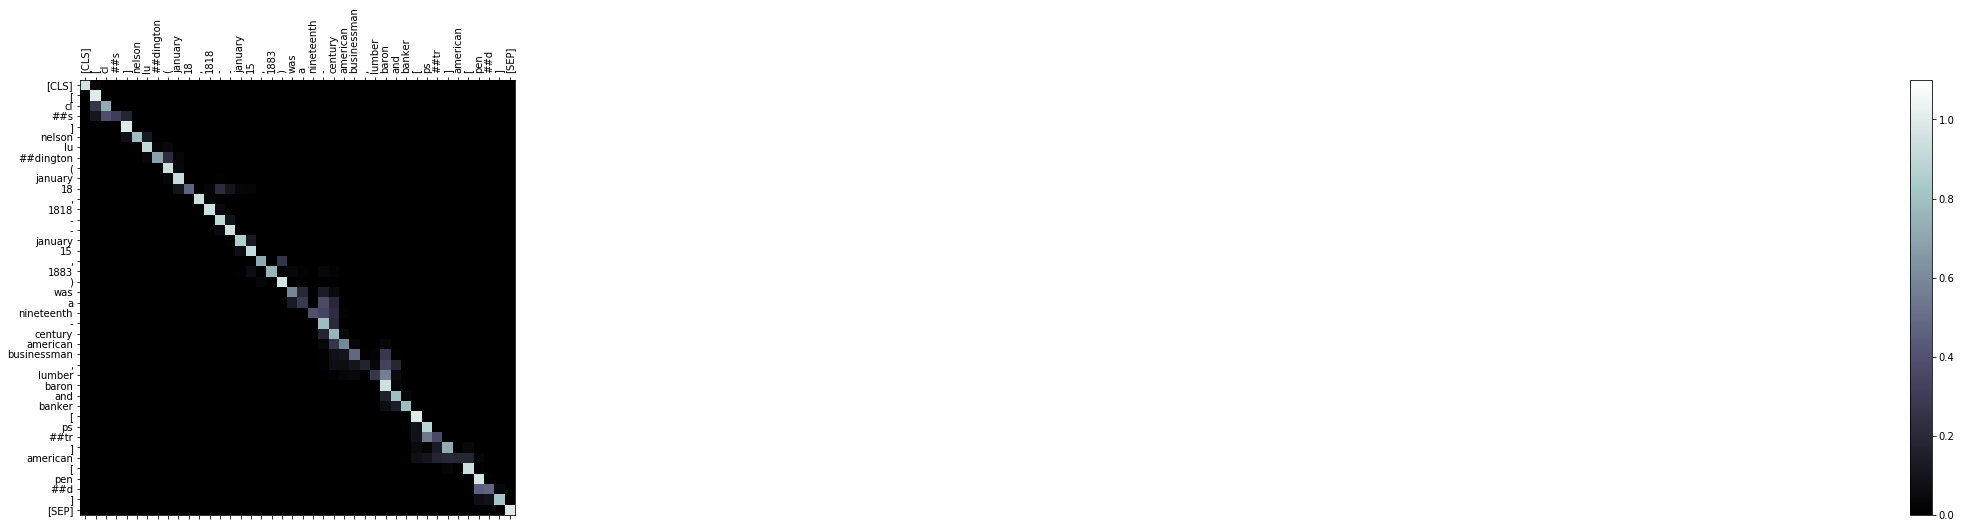

In [222]:
model.eval()
n_correct = loss = totoal_size = 0
with torch.no_grad():  # Important fixing.

    for batch_idx, batch in enumerate(eval_iter):
        batch = nn_util.move_to_device(batch, 0 if USE_GPU else -1)
        (out, attn), s1 = model(batch)
        if '[PAD]' in s1[0]:
          padding=s1[0].index('[PAD]')
        else:
          padding=len(s1[0])
        show_attention(s1[0][:padding],s1[0][:padding],attn.cpu()[0][:padding,:padding])
        break

In [215]:
tedata

,Unnamed: 0,base_sentence,phrase,edited_sentence,label,base_tokens,phrase_tokens,edited_tokens,Final_Text
213,213,"nelson ludington ( january 18 , 1818 -- januar...",american,"nelson ludington ( january 18 , 1818 -- januar...",Elaboration(insert a fact or new meaningful as...,"['nelson', 'ludington', '(', 'january', '18', ...",['american'],"['[CLS]', 'nelson', 'ludington', '(', 'january...","[CLS] nelson ludington ( january 18 , 1818 -- ..."
431,431,currently union has 40000 members in 9 distric...,senior 's,currently senior 's union has 40000 members in...,Copy Editing(Rephrase without changing meaning...,"['currently', 'union', 'has', '40000', 'member...","['senior', ""'s""]","['[CLS]', 'currently', '[ps]', 'senior', ""'s"",...",[CLS] currently [ps] senior 's [pe] union has ...
137,137,"from 1990 to 2004 , he was member of the",parliament of georgia,"from 1990 to 2004 , he was member of the parli...",Elaboration(insert a fact or new meaningful as...,"['from', '1990', 'to', '2004', ',', 'he', 'was...","['parliament', 'of', 'georgia']","['[CLS]', 'from', '1990', 'to', '2004', ',', '...","[CLS] from 1990 to 2004 , he was member of the..."
316,316,the patronage of the church of holm then consi...,high ranking,the patronage of the church of holm then consi...,Elaboration(insert a fact or new meaningful as...,"['the', 'patronage', 'of', 'the', 'church', 'o...","['high', 'ranking']","['[CLS]', 'the', 'patronage', 'of', 'the', 'ch...",[CLS] the patronage of the church of holm then...
186,186,sceptic is a polish death metal band from krak...,", founded in 1994 by jacek hiro",sceptic is a polish death metal band from krak...,Copy Editing(Rephrase without changing meaning...,"['sceptic', 'is', 'a', 'polish', 'death', 'met...","[',', 'founded', 'in', '1994', 'by', 'jacek', ...","['[CLS]', 'sceptic', 'is', 'a', 'polish', 'dea...",[CLS] sceptic is a polish death metal band fro...
...,...,...,...,...,...,...,...,...,...
126,126,the song that was written also by larraz becam...,and gustavo montesano,the song that was written also by larraz and g...,Elaboration(insert a fact or new meaningful as...,"['the', 'song', 'that', 'was', 'written', 'als...","['and', 'gustavo', 'montesano']","['[CLS]', 'the', 'song', 'that', 'was', 'writt...",[CLS] the song that was written also by larraz...
258,258,it also managed to reach # 11 on the us billbo...,"with 27,522 first week sales",it also managed to reach # 11 on the us billbo...,Elaboration(insert a fact or new meaningful as...,"['it', 'also', 'managed', 'to', 'reach', '#', ...","['with', '27,522', 'first', 'week', 'sales']","['[CLS]', 'it', 'also', 'managed', 'to', 'reac...",[CLS] it also managed to reach # 11 on the us ...
457,457,international labor migration surged during th...,primarily because domestic employment opportun...,international labor migration surged during th...,Copy Editing(Rephrase without changing meaning...,"['international', 'labor', 'migration', 'surge...","['primarily', 'because', 'domestic', 'employme...","['[CLS]', 'international', 'labor', 'migration...",[CLS] international labor migration surged dur...
268,268,"in 1887 , he returned to london as secretary o...",", duke of clarence","in 1887 , he returned to london as secretary o...",Elaboration(insert a fact or new meaningful as...,"['in', '1887', ',', 'he', 'returned', 'to', 'l...","[',', 'duke', 'of', 'clarence']","['[CLS]', 'in', '1887', '[ps]', ',', 'he', 're...","[CLS] in 1887 [ps] , he returned to london as ..."


In [0]:
l=[1.33,1.02,0.97,0.86,0.72]
l = pd.DataFrame(l,columns=['Loss'])

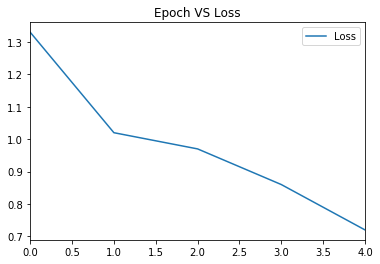

In [228]:
l.plot(title='Epoch VS Loss')